<a href="https://colab.research.google.com/github/LvJiaaaaY/Stock-Prediction-Project/blob/main/transformer%5BDataFrame%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [239]:
import math
import numpy as np
import pandas as pd
import tqdm
import matplotlib.pyplot as pyplot
import torch
import torch.nn as nn
import seaborn
import time

torch.manual_seed(0)
np.random.seed(0)

calculate_loss_over_all_values = False

from pandas_datareader import data as wb
import yfinance as yfin
yfin.pdr_override()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
                   AMT        EQIX         PSA     SPG-PJ
Date                                                     
2023-07-27  193.229996  796.070007  288.329987  59.318901
2023-07-28  188.970001  797.359985  281.529999  58.759998
2023-07-31  190.309998  809.919983  281.750000  59.375198
2023-08-01  191.240005  805.159973  279.350006  59.000000
2023-08-02  190.619995  805.630005  278.769989  57.599998


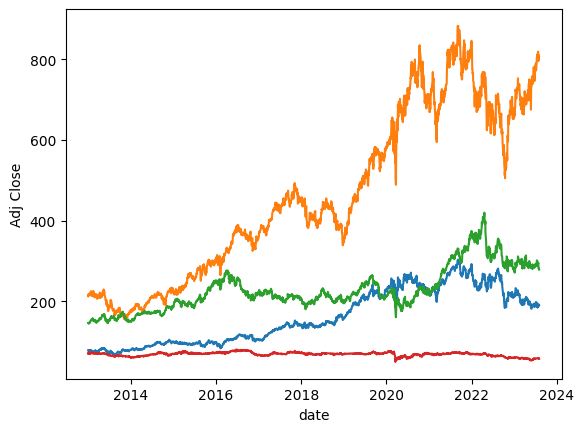

In [240]:
# Parameter for data
# Start Date
start_date='2013-01-01'
## End Date
end_date='2023-08-03'
## Split ratio of train data and validation data
train_rate=0.8
## How many business days to see
input_window=10
## How many business days to predict
output_window=1

# Parameter for mdoel
batch_size=64

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#多个股票同时输入
code_list=['AMT',"EQIX",'PSA','SPG-PJ']#,'PLD'
data_list =[]
for code in code_list:
  data = wb.DataReader(code,start=start_date,end=end_date)['Close'].to_frame()
  data.rename(columns={'Close':code}, inplace = True)
  data_list.append(data)#获取的第二个股票数据接在第一个股票的右边
data = pd.concat(data_list,axis = 1)
print(data.tail())

plt.plot(data)
plt.xlabel('date')
plt.ylabel('Adj Close')
plt.show()

In [241]:
mean_list=data.mean().values
std_list=data.std().values
data=(data-mean_list)/std_list
data

AMT      EQIX       PSA    SPG-PJ
Date                                              
2013-01-02 -1.219379 -1.196958 -1.523207  0.261038
2013-01-03 -1.248019 -1.210970 -1.533117  0.261038
2013-01-04 -1.249058 -1.195750 -1.520821  0.454898
2013-01-07 -1.250394 -1.178742 -1.525776  1.156586
2013-01-08 -1.245793 -1.195992 -1.543945  0.455108
...              ...       ...       ...       ...
2023-07-27  0.475012  1.610595  1.087299 -2.006509
2023-07-28  0.411795  1.616828  0.962500 -2.124279
2023-07-31  0.431680  1.677516  0.966538 -1.994646
2023-08-01  0.445481  1.654516  0.922491 -2.073707
2023-08-02  0.436280  1.656787  0.911846 -2.368711

[2664 rows x 4 columns]

In [242]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    # print(L)
    for i in range(L-tw):
        train_seq = np.append(input_data[i:i+tw,:][:-output_window,:] , np.zeros((output_window,4)),axis=0)
        train_label = input_data[i:i+tw,:]
        # print(train_seq.shape,train_label.shape)
        #train_label = input_data[i+output_window:i+tw+output_window]
        inout_seq.append((train_seq ,train_label))
    return torch.FloatTensor(inout_seq)

def get_data(data):
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    #data = data_.loc[(data_["date"] >= pd.Timestamp(date(2014, 1, 1))) & (data_["date"] <= pd.Timestamp(date(2014, 2, 10)))]
    #data = data.loc[:, "MT_200":  "MT_209"]
    series = data.to_numpy()
    # print('a',series.shape)
    amplitude = scaler.fit_transform(series)
    # print('b', amplitude.shape)
    # amplitude = scaler.fit_transform(amplitude.reshape(-1, 1)).reshape(-1)

    # print(amplitude.shape)
    samples = int(np.shape(data)[0]*train_rate)
    train_data = amplitude[:samples]
    test_data = amplitude[samples:]

    # print(train_data.shape,test_data.shape)
    # convert our train data into a pytorch train tensor
    # train_tensor = torch.FloatTensor(train_data).view(-1)
    # todo: add comment..
    # print('c',train_data.shape)

    train_sequence = create_inout_sequences(train_data,input_window)
    # print('a',train_sequence.size())
    train_sequence = train_sequence[:-output_window] #todo: fix hack?

    #test_data = torch.FloatTensor(test_data).view(-1)
    test_data = create_inout_sequences(test_data,input_window)
    test_data = test_data[:-output_window] #todo: fix hack?

    return train_sequence.to(device),test_data.to(device),scaler

def get_batch(source, i,batch_size):
    seq_len = min(batch_size, len(source) - 1 - i)
    data = source[i:i+seq_len]
    input = torch.stack(torch.stack([item[0] for item in data]).chunk(input_window,1)).squeeze()# 1 is feature size
    target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window,1)).squeeze()
    return input, target

In [243]:
train_data, val_data,scaler = get_data(data)
print(train_data.size())
# print(train_data.size(), val_data.size())
tr,te = get_batch(train_data, 0,batch_size)
print(tr.shape,te.shape)

torch.Size([2120, 2, 10, 4])
torch.Size([10, 64, 4]) torch.Size([10, 64, 4])


In [244]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)

        #pe.requires_grad = False
        self.register_buffer('pe', pe)

    def forward(self, x):

        return x + self.pe[:x.size(0), :]

In [245]:
class TransAm(nn.Module):
    def __init__(self,feature_size=4,num_layers=3,dropout=0.1):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'

        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=4, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(feature_size,feature_size)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        #self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            # print('a',src.size())
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.pos_encoder(src)
        # print('j',src.size(),self.src_mask.size())
        output = self.transformer_encoder(src,self.src_mask)#, self.src_mask)

        output = self.decoder(output)

        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

In [246]:
def train(train_data):
    model.train() # Turn on the train mode
    total_loss = 0.
    start_time = time.time()

    for batch, i in enumerate(range(0, len(train_data) - 1, batch_size)):
        data, targets = get_batch(train_data, i,batch_size)
        optimizer.zero_grad()
        output = model(data)

        if calculate_loss_over_all_values:
            loss = criterion(output, targets)
        else:
            loss = criterion(output[-output_window:], targets[-output_window:])

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        log_interval = int(len(train_data) / batch_size / 5)
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.6f} | {:5.2f} ms | '
                  'loss {:5.5f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // batch_size, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

In [247]:
def plot_and_loss(eval_model, data_source,epoch,scaler):
    eval_model.eval()
    total_loss = 0.
    test_result = torch.Tensor(0)
    truth = torch.Tensor(0)
    with torch.no_grad():
        for i in range(0, len(data_source) - 1):
            data, target = get_batch(data_source, i,1)
            data = data.unsqueeze(1)
            target = target.unsqueeze(1)

            # look like the model returns static values for the output window
            output = eval_model(data)

            if calculate_loss_over_all_values:
                total_loss += criterion(output, target).item()
            else:
                total_loss += criterion(output[-output_window:], target[-output_window:]).item()


            test_result = torch.cat((test_result, output[-1,:].squeeze(1).cpu()), 0) #todo: check this. -> looks good to me
            truth = torch.cat((truth, target[-1,:].squeeze(1).cpu()), 0)

    #test_result = test_result.cpu().numpy()
    len(test_result)

    print(test_result.size(),truth.size())
    test_result=scaler.inverse_transform(test_result.reshape(-1, 1)).reshape(-1)
    truth=scaler.inverse_transform(truth.reshape(-1, 1)).reshape(-1)

    pyplot.plot(test_result,color="red")
    pyplot.plot(truth[:500],color="blue")
    pyplot.axhline(y=0, color='k')
    pyplot.xlabel("Periods")
    pyplot.ylabel("Y")
    pyplot.savefig('graph/transformer-epoch%d.png'%epoch)
    pyplot.close()
    return total_loss / i


def predict_future(eval_model, data_source,steps,epoch,scaler):
    eval_model.eval()
    total_loss = 0.
    test_result = torch.Tensor(0)
    truth = torch.Tensor(0)
    _ , data = get_batch(data_source, 0,1)
    with torch.no_grad():
        for i in range(0, steps,1):
            input = torch.clone(data[-input_window:])
            input[-output_window:] = 0
            output = eval_model(data[-input_window:])
            data = torch.cat((data, output[-1:]))

    data = data.cpu().view(-1)

    data=scaler.inverse_transform(data.reshape(-1, 1)).reshape(-1)
    pyplot.plot(data,color="red")
    pyplot.plot(data[:input_window],color="blue")
    pyplot.grid(True, which='both')
    pyplot.axhline(y=0, color='k')
    pyplot.savefig('graph/transformer-future%d.png'%epoch)
    pyplot.close()

# entweder ist hier ein fehler im loss oder in der train methode, aber die ergebnisse sind unterschiedlich
# auch zu denen der predict_future
def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    eval_batch_size = 1000
    with torch.no_grad():
        for i in range(0, len(data_source) - 1, eval_batch_size):
            data, targets = get_batch(data_source, i,eval_batch_size)
            output = eval_model(data)
            print(output[-output_window:].size(),targets[-output_window:].size())
            if calculate_loss_over_all_values:
                total_loss += len(data[0])* criterion(output, targets).cpu().item()
            else:
                total_loss += len(data[0])* criterion(output[-output_window:], targets[-output_window:]).cpu().item()
    return total_loss / len(data_source)

In [250]:

def plot(eval_model, data_source,epoch,scaler):
    eval_model.eval()
    total_loss = 0.
    test_result = torch.Tensor(0)
    truth = torch.Tensor(0)
    with torch.no_grad():
        for i in range(0, len(data_source) - 1):
            data, target = get_batch(data_source, i,1)
            data = data.unsqueeze(1)
            target = target.unsqueeze(1)
            # look like the model returns static values for the output window
            output = eval_model(data)
            if calculate_loss_over_all_values:
                total_loss += criterion(output, target).item()
            else:
                total_loss += criterion(output[-output_window:], target[-output_window:]).item()

            test_result = torch.cat((test_result, output[-1,:].squeeze(1).cpu()), 0) #todo: check this. -> looks good to me
            truth = torch.cat((truth, target[-1,:].squeeze(1).cpu()), 0)

    #test_result = test_result.cpu().numpy()
    len(test_result)

    test_result_=scaler.inverse_transform(test_result[:700])
    truth_=scaler.inverse_transform(truth)
    print(test_result.shape,truth.shape)
    for m in range(4):
        test_result = test_result_[:,m]
        truth = truth_[:,m]
        fig = pyplot.figure(1, figsize=(20, 5))
        fig.patch.set_facecolor('xkcd:white')
        pyplot.plot([k + 310 for k in range(211)],test_result[310:],color="red")
        pyplot.title('Prediction uncertainty')
        pyplot.plot(truth[:700],color="black")
        pyplot.legend(["prediction", "true"], loc="upper left")
        ymin, ymax = pyplot.ylim()
        pyplot.vlines(310, ymin, ymax, color="blue", linestyles="dashed", linewidth=2)
        pyplot.ylim(ymin, ymax)
        pyplot.xlabel("Periods")
        pyplot.ylabel("Price")
        pyplot.show()
        pyplot.close()
    return total_loss / i

<>:19: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:19: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-252-32cba6475377>:19: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if(epoch % 1 is 0):
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:389: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch   1 |     6/   33 batches | lr 0.000050 | 89.27 ms | loss 0.86092 | ppl     2.37
| epoch   1 |    12/   33 batches | lr 0.000050 | 73.87 ms | loss 0.44074 | ppl     1.55
| epoch   1 |    18/   33 batches | lr 0.000050 | 70.64 ms | loss 0.22255 | ppl     1.25
| epoch   1 |    24/   33 batches | lr 0.000050 | 66.44 ms | loss 0.11385 | ppl     1.12
| epoch   1 |    30/   33 batches | lr 0.000050 | 65.94 ms | loss 0.19491 | ppl     1.22
torch.Size([521, 4]) torch.Size([521, 4])


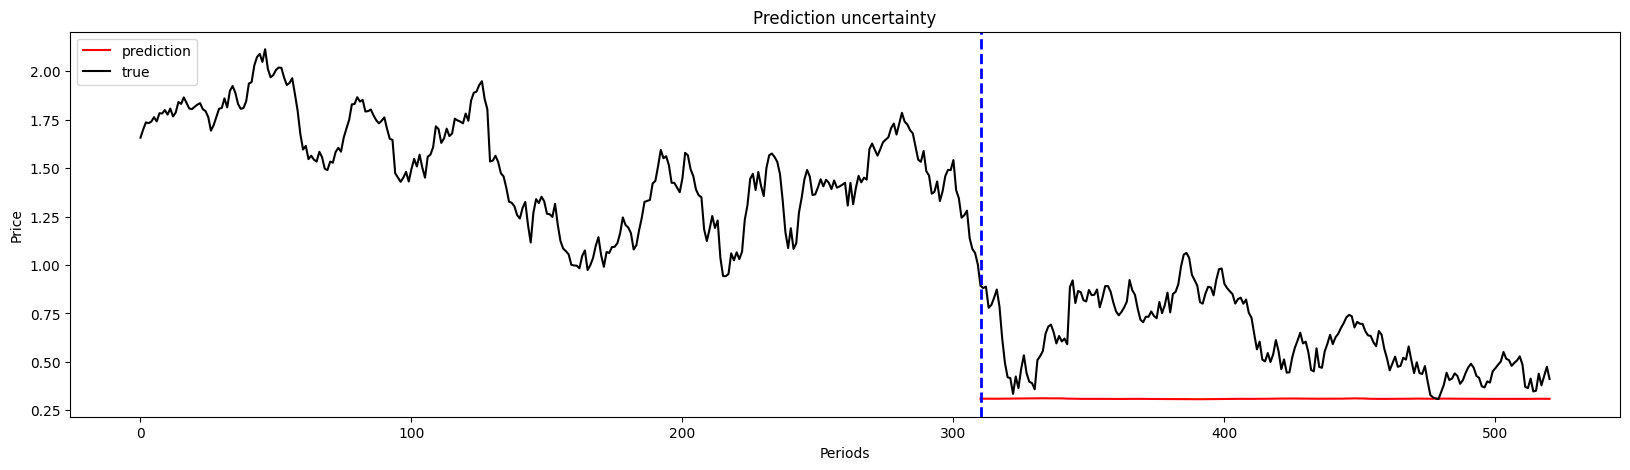

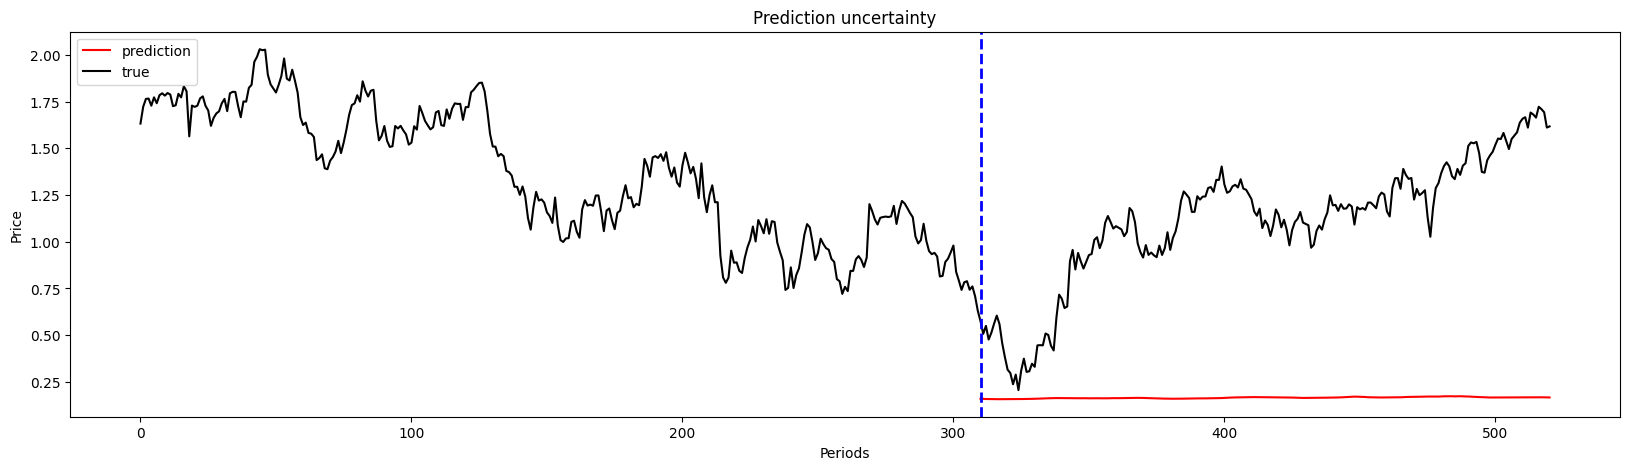

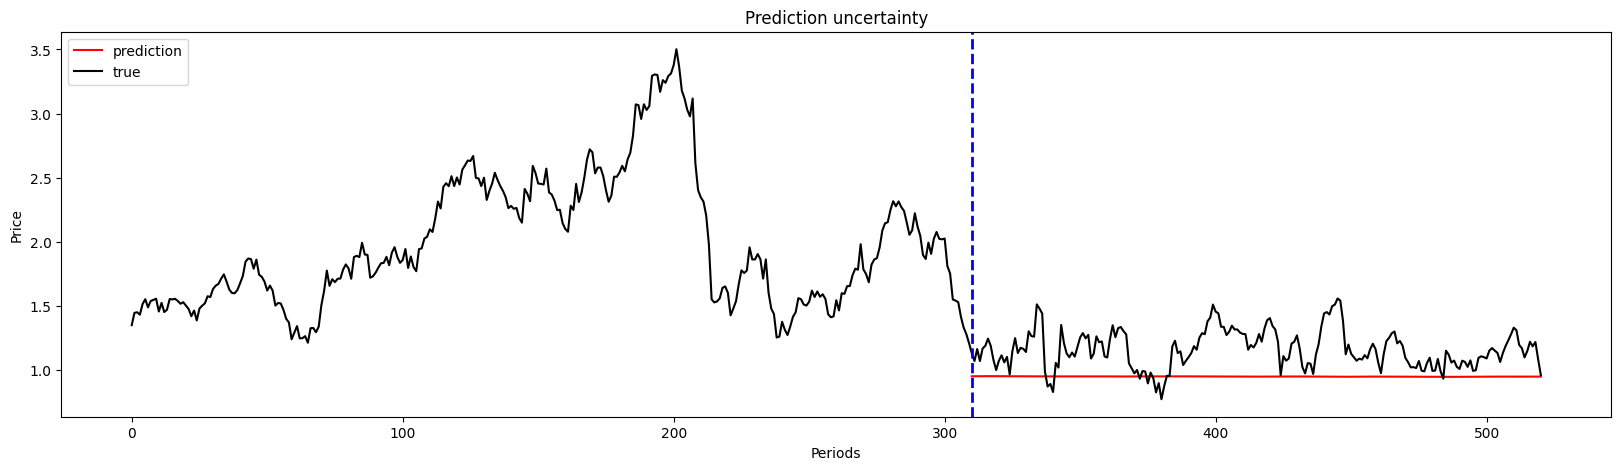

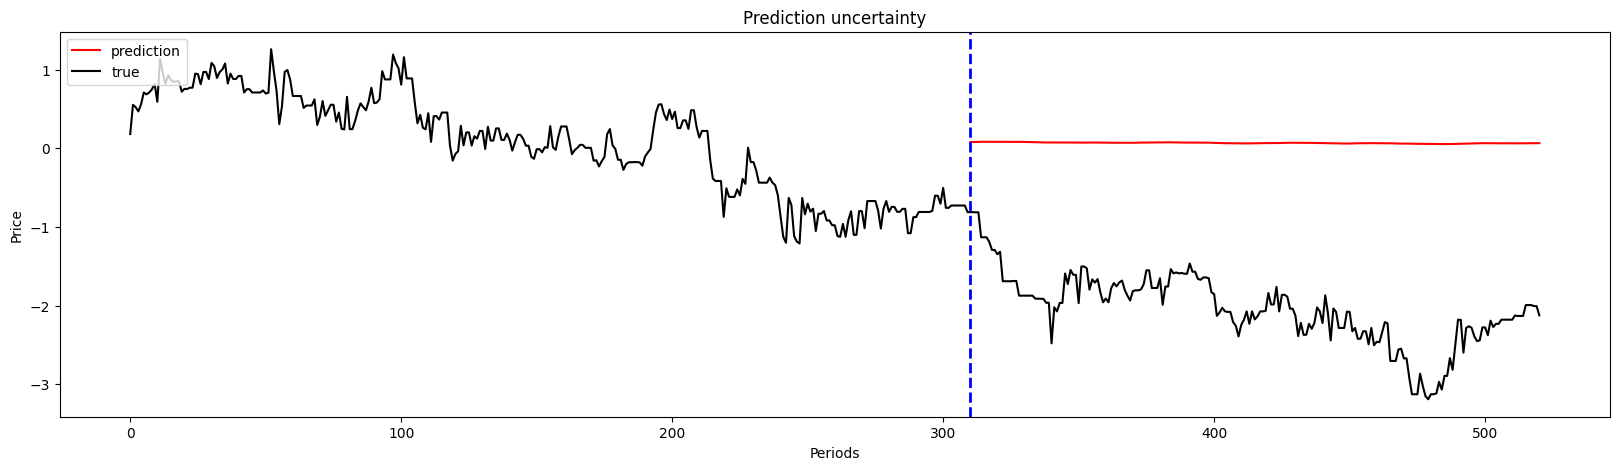

-----------------------------------------------------------------------------------------
| end of epoch   1 | time:  4.02s | valid loss 0.26755 | valid ppl     1.31
-----------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:389: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch   2 |     6/   33 batches | lr 0.000048 | 74.76 ms | loss 0.65114 | ppl     1.92
| epoch   2 |    12/   33 batches | lr 0.000048 | 65.23 ms | loss 0.30406 | ppl     1.36
| epoch   2 |    18/   33 batches | lr 0.000048 | 64.23 ms | loss 0.16644 | ppl     1.18
| epoch   2 |    24/   33 batches | lr 0.000048 | 64.73 ms | loss 0.09954 | ppl     1.10
| epoch   2 |    30/   33 batches | lr 0.000048 | 64.71 ms | loss 0.21763 | ppl     1.24
torch.Size([521, 4]) torch.Size([521, 4])


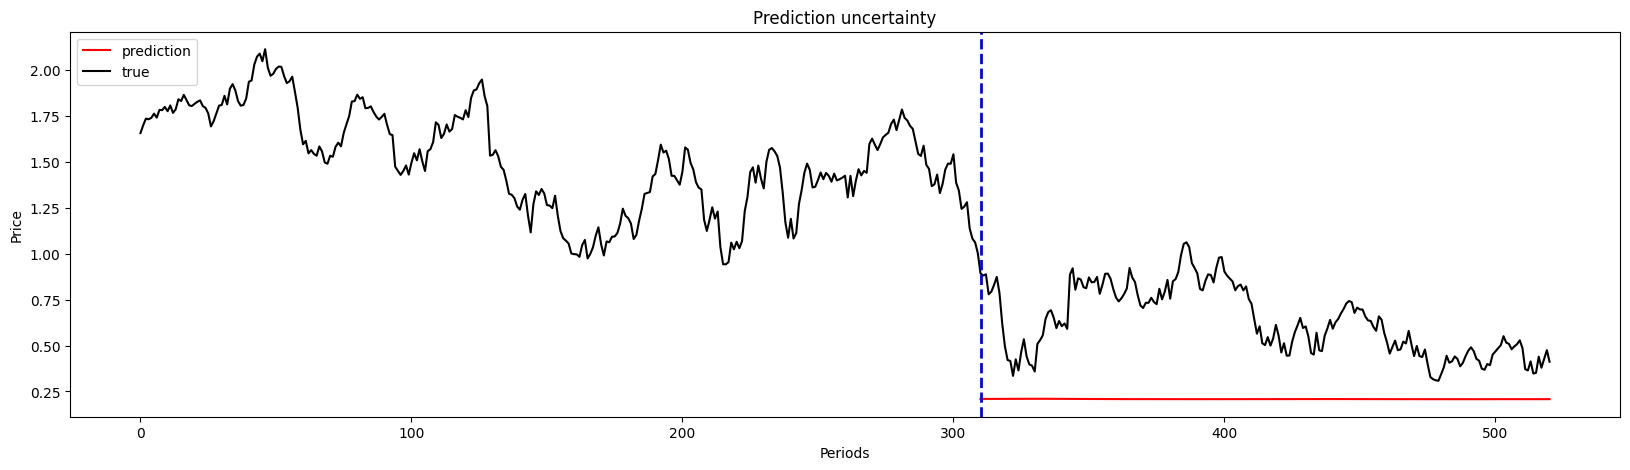

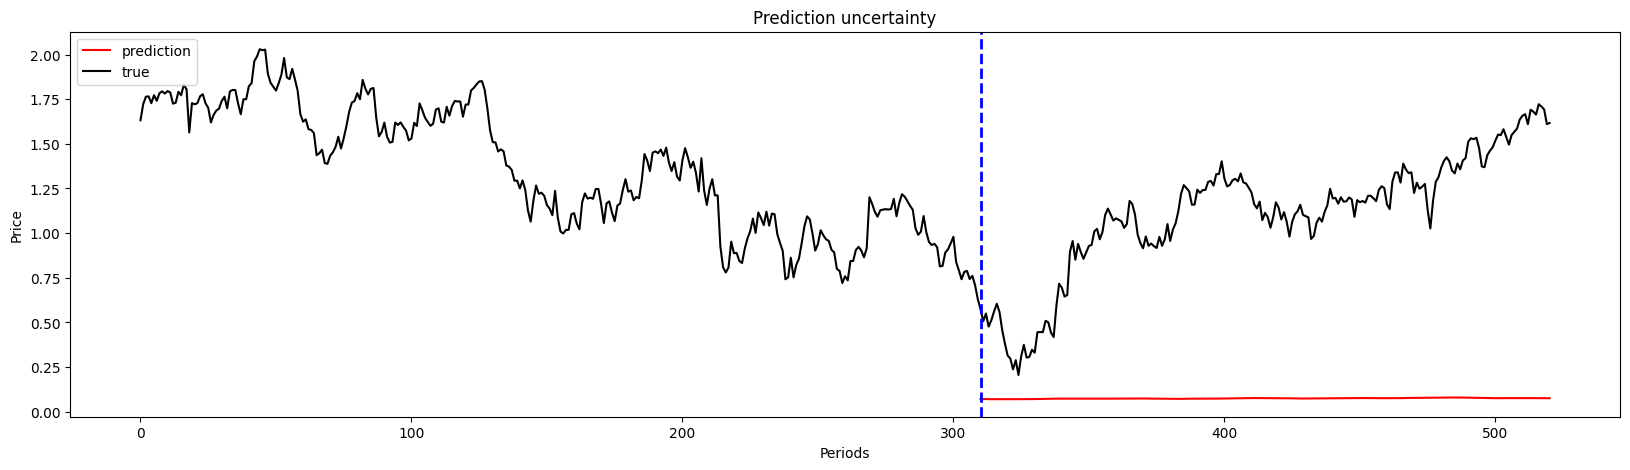

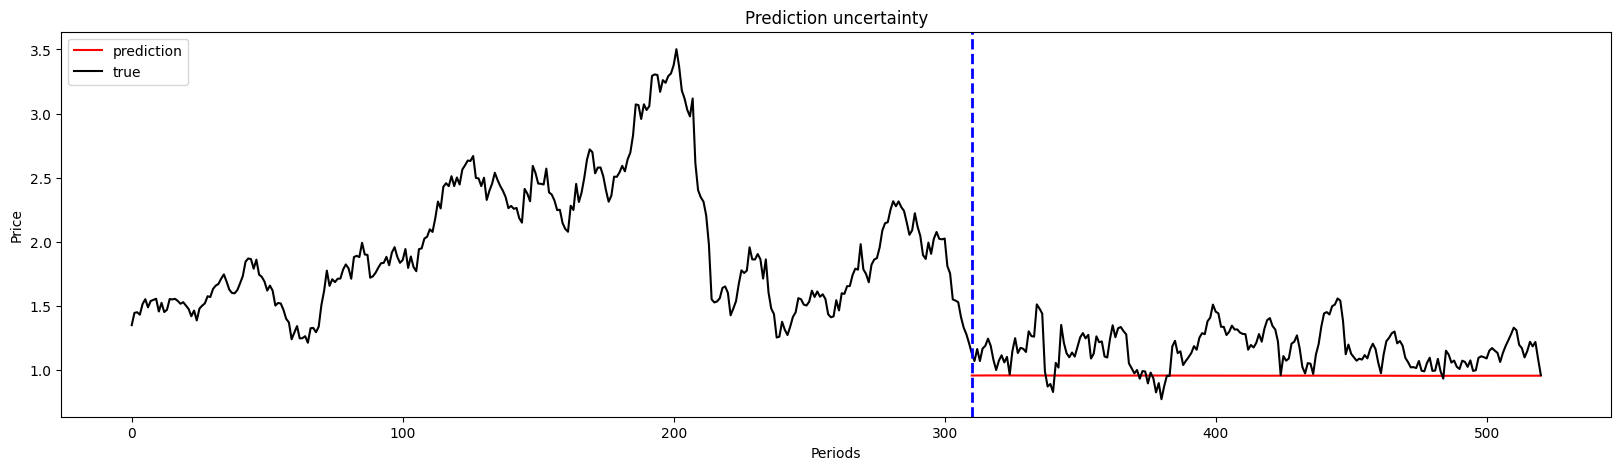

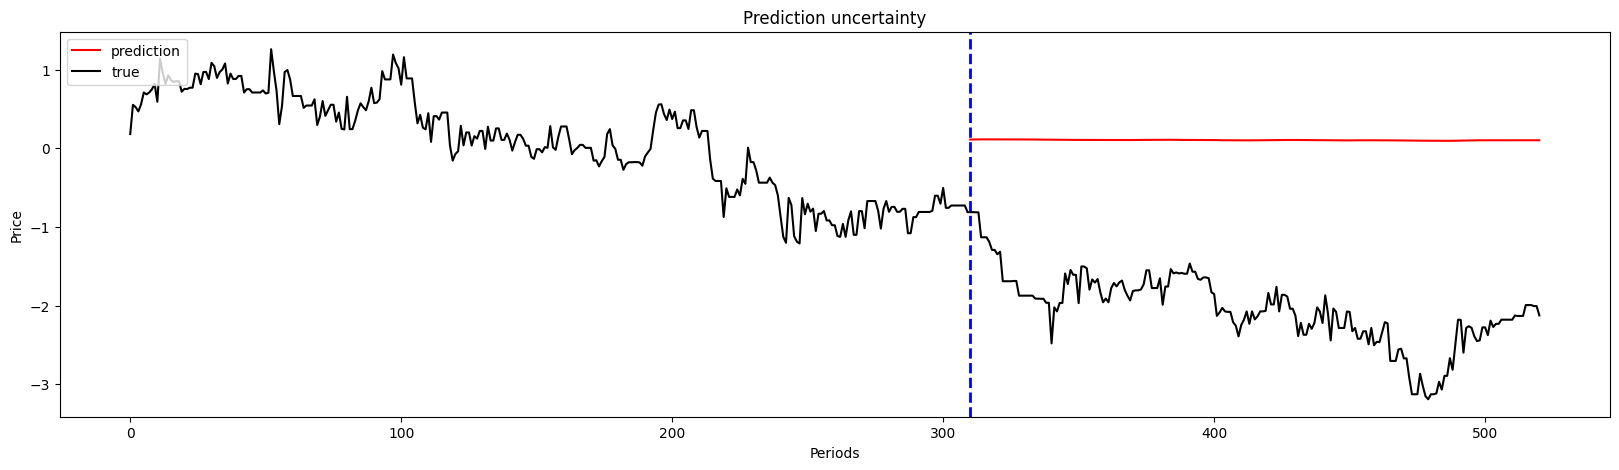

-----------------------------------------------------------------------------------------
| end of epoch   2 | time:  3.78s | valid loss 0.30006 | valid ppl     1.35
-----------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:389: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch   3 |     6/   33 batches | lr 0.000047 | 76.22 ms | loss 0.60504 | ppl     1.83
| epoch   3 |    12/   33 batches | lr 0.000047 | 66.39 ms | loss 0.27483 | ppl     1.32
| epoch   3 |    18/   33 batches | lr 0.000047 | 66.31 ms | loss 0.15148 | ppl     1.16
| epoch   3 |    24/   33 batches | lr 0.000047 | 63.73 ms | loss 0.09482 | ppl     1.10
| epoch   3 |    30/   33 batches | lr 0.000047 | 68.87 ms | loss 0.22609 | ppl     1.25
torch.Size([521, 4]) torch.Size([521, 4])


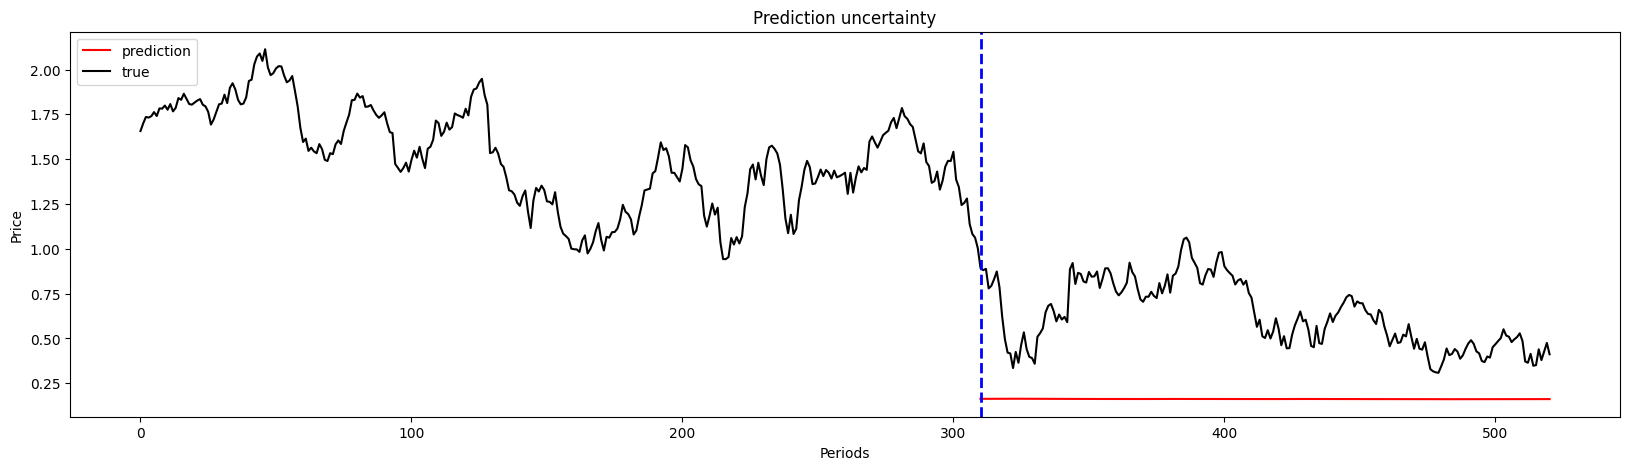

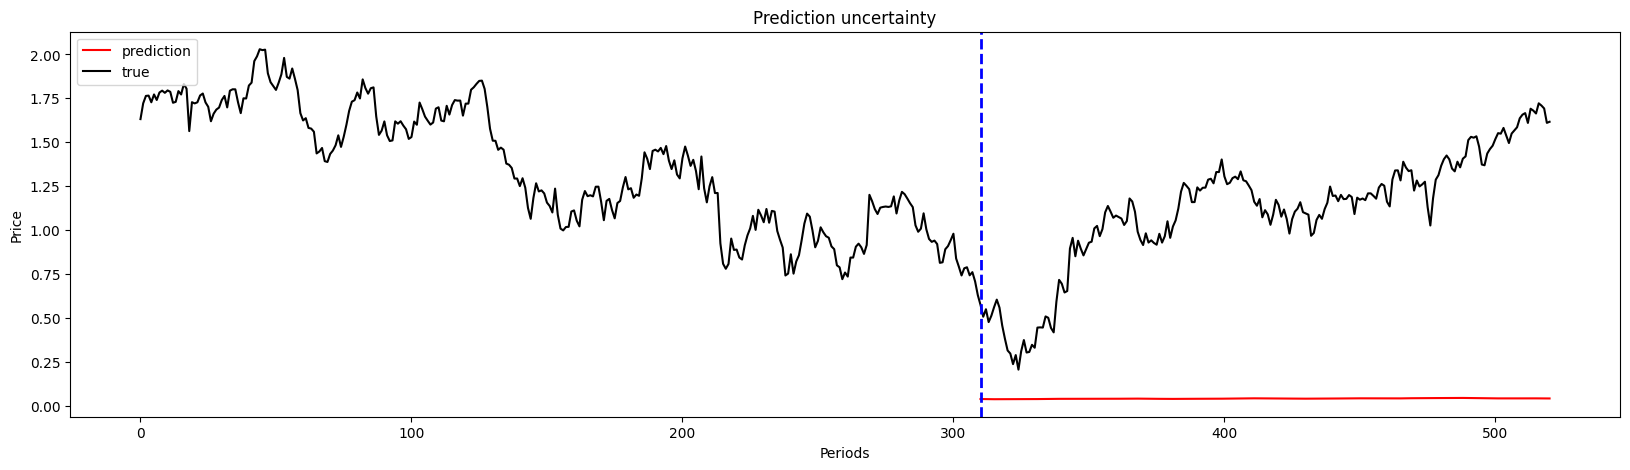

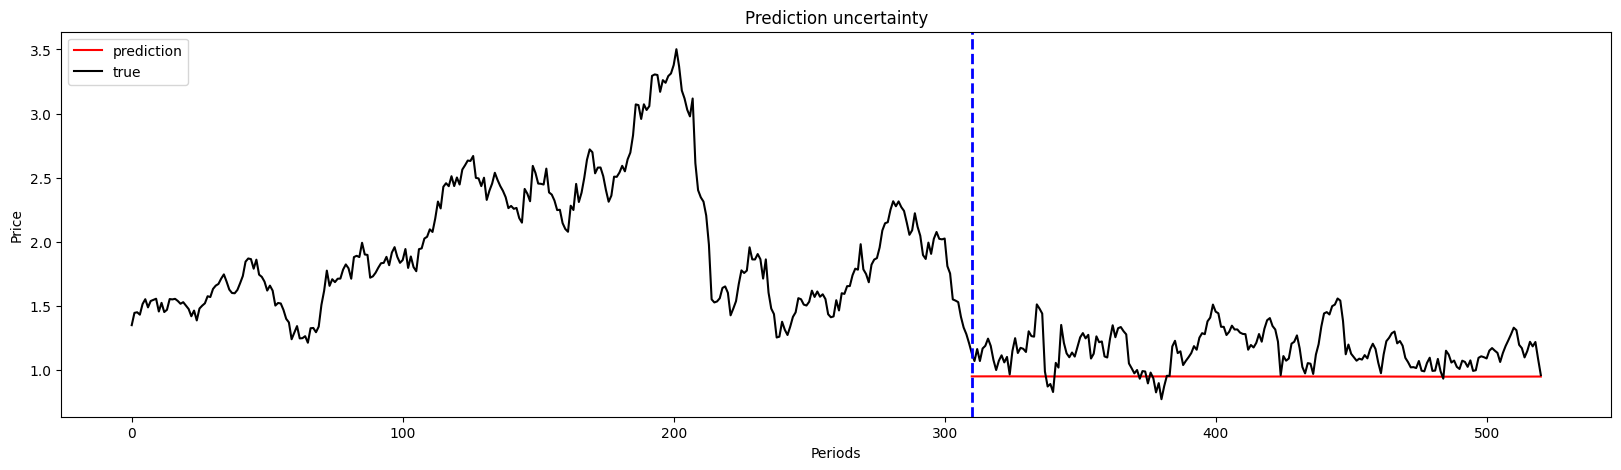

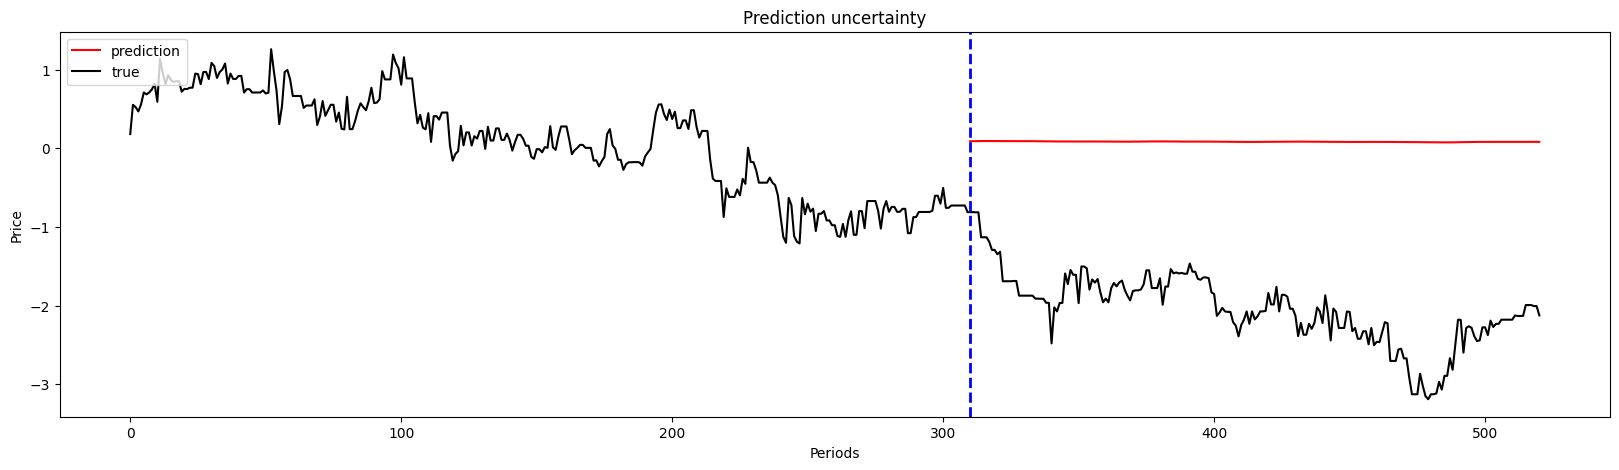

-----------------------------------------------------------------------------------------
| end of epoch   3 | time:  4.12s | valid loss 0.31344 | valid ppl     1.37
-----------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:389: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch   4 |     6/   33 batches | lr 0.000046 | 83.36 ms | loss 0.58374 | ppl     1.79
| epoch   4 |    12/   33 batches | lr 0.000046 | 77.44 ms | loss 0.26222 | ppl     1.30
| epoch   4 |    18/   33 batches | lr 0.000046 | 68.09 ms | loss 0.14583 | ppl     1.16
| epoch   4 |    24/   33 batches | lr 0.000046 | 63.29 ms | loss 0.09196 | ppl     1.10
| epoch   4 |    30/   33 batches | lr 0.000046 | 66.24 ms | loss 0.23020 | ppl     1.26
torch.Size([521, 4]) torch.Size([521, 4])


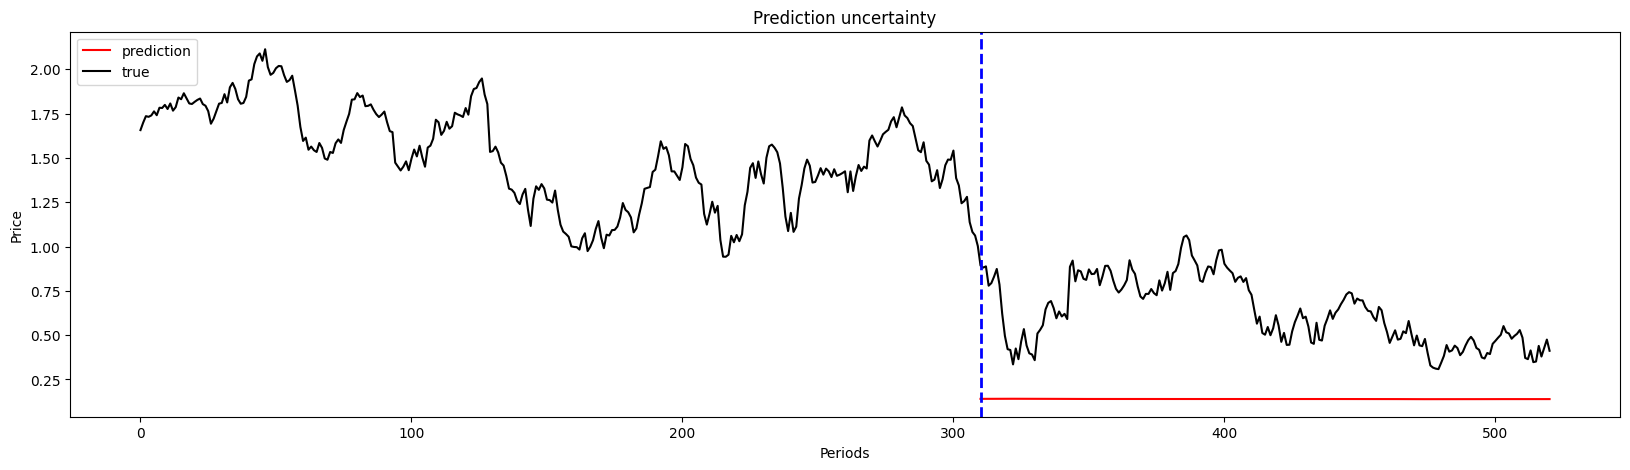

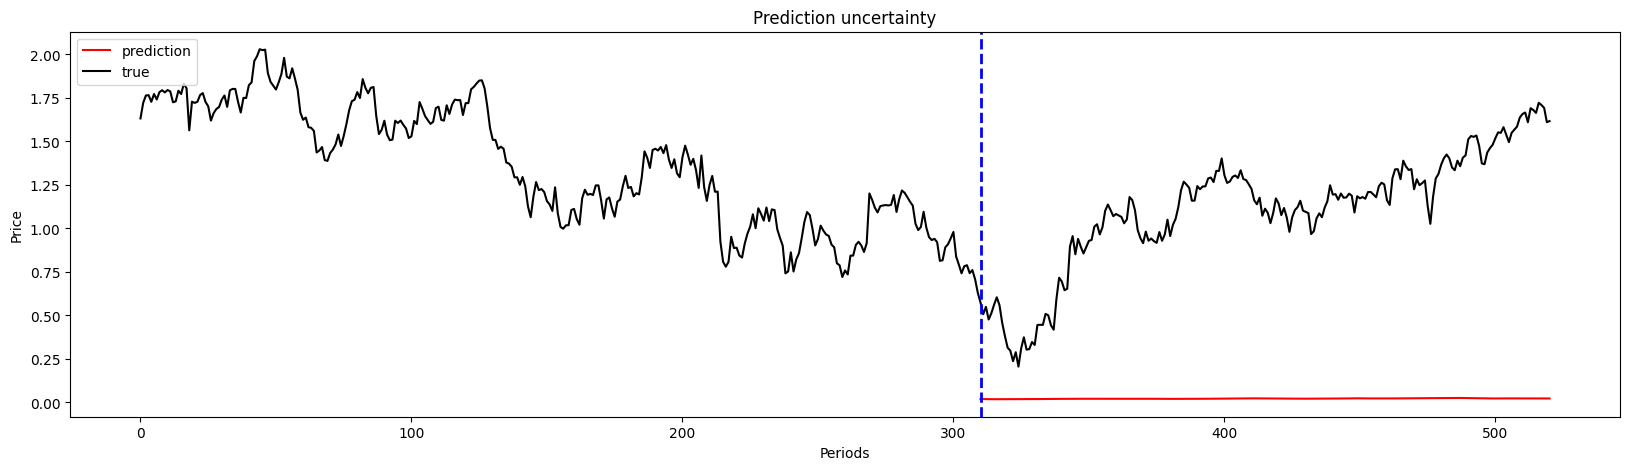

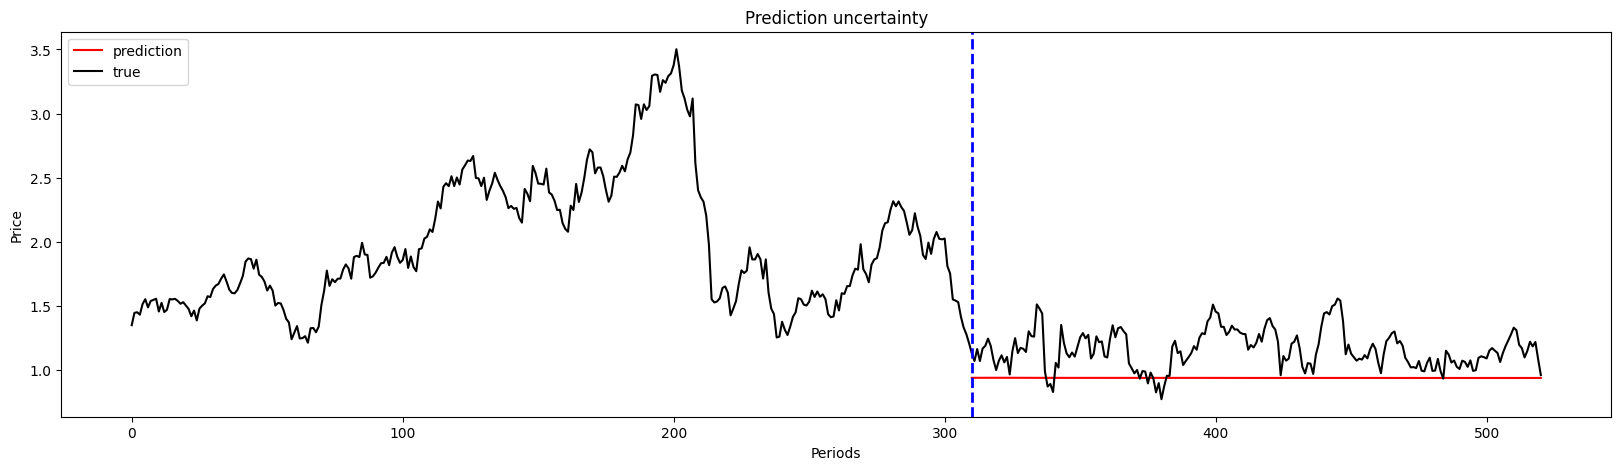

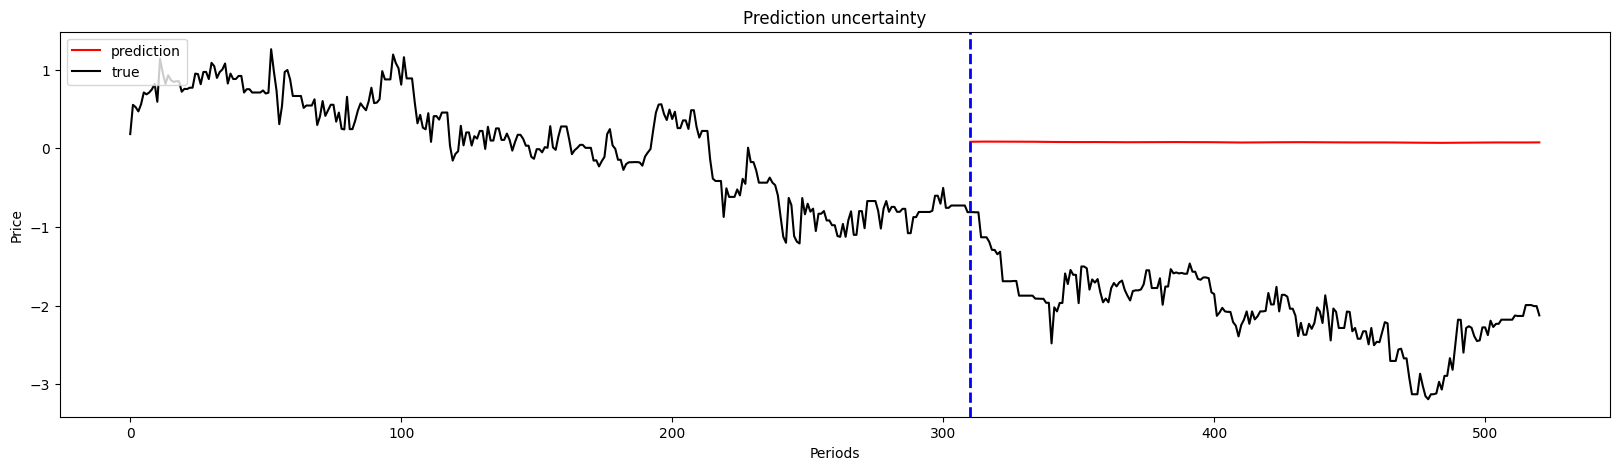

-----------------------------------------------------------------------------------------
| end of epoch   4 | time:  3.98s | valid loss 0.32125 | valid ppl     1.38
-----------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:389: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch   5 |     6/   33 batches | lr 0.000045 | 77.97 ms | loss 0.57017 | ppl     1.77
| epoch   5 |    12/   33 batches | lr 0.000045 | 64.83 ms | loss 0.25467 | ppl     1.29
| epoch   5 |    18/   33 batches | lr 0.000045 | 64.17 ms | loss 0.14223 | ppl     1.15
| epoch   5 |    24/   33 batches | lr 0.000045 | 62.77 ms | loss 0.08985 | ppl     1.09
| epoch   5 |    30/   33 batches | lr 0.000045 | 64.87 ms | loss 0.23310 | ppl     1.26
torch.Size([521, 4]) torch.Size([521, 4])


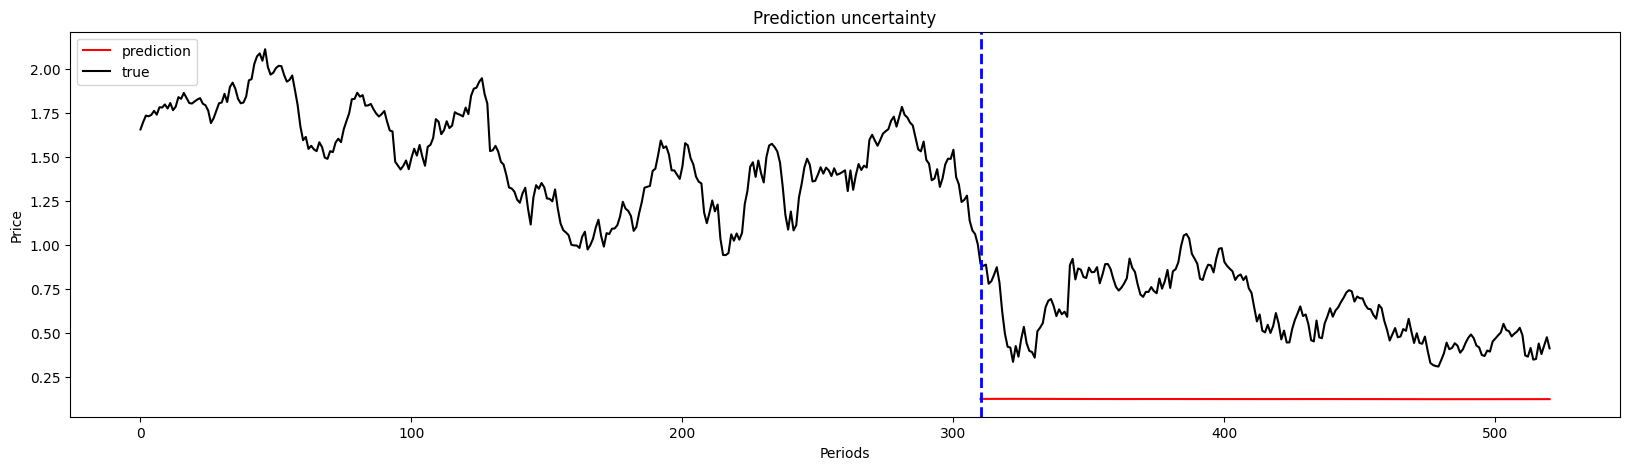

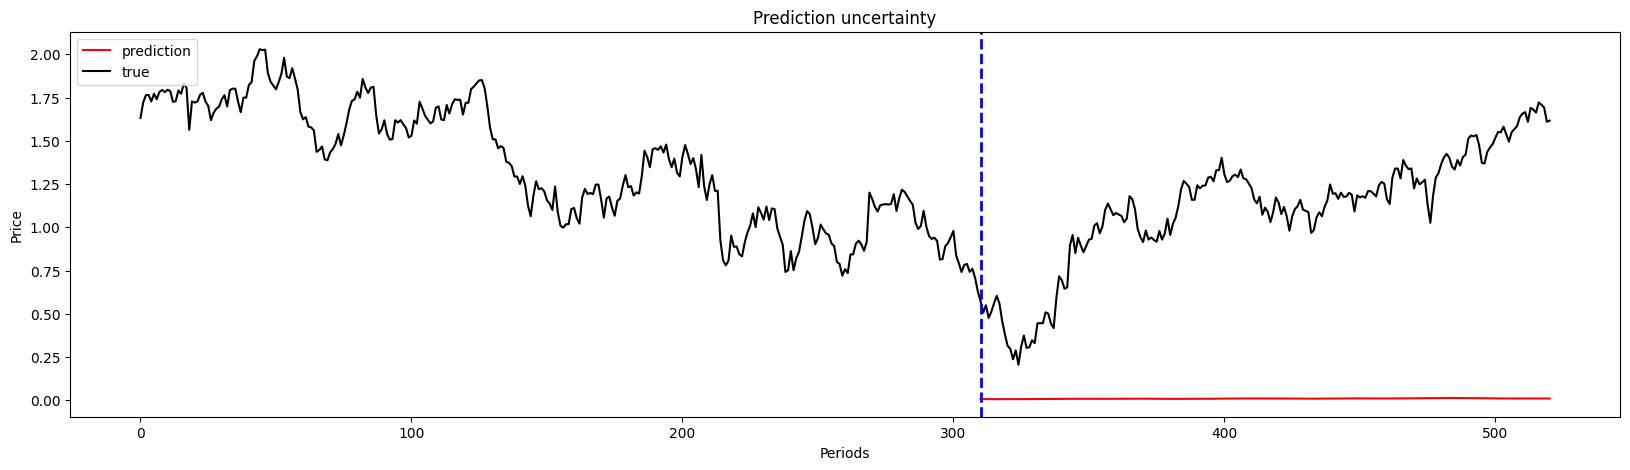

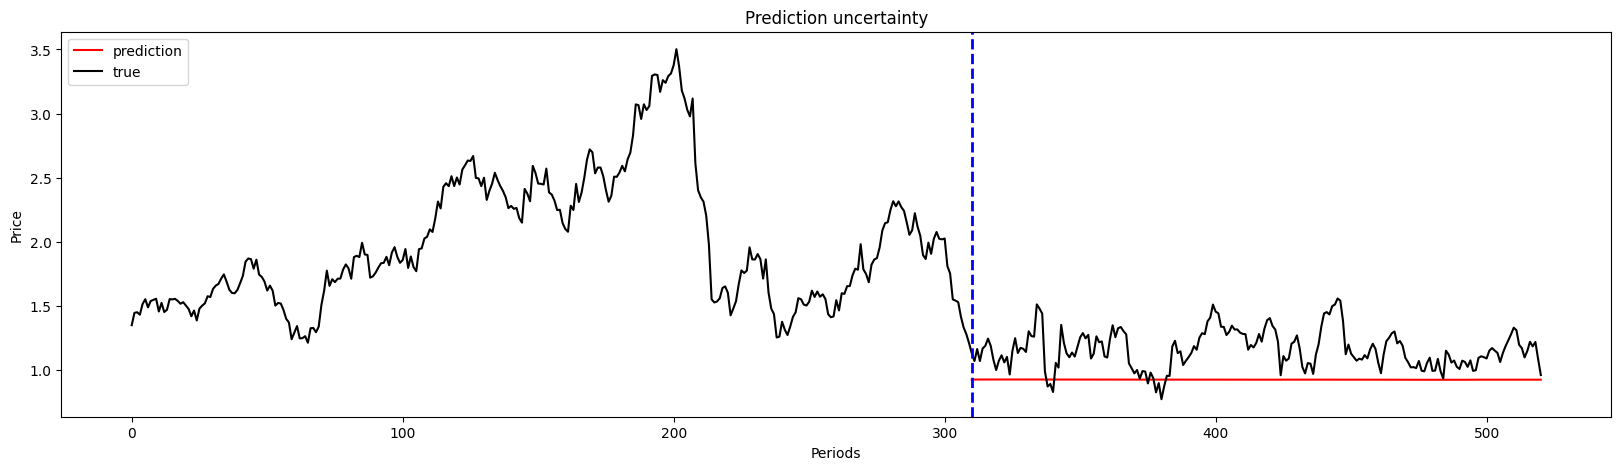

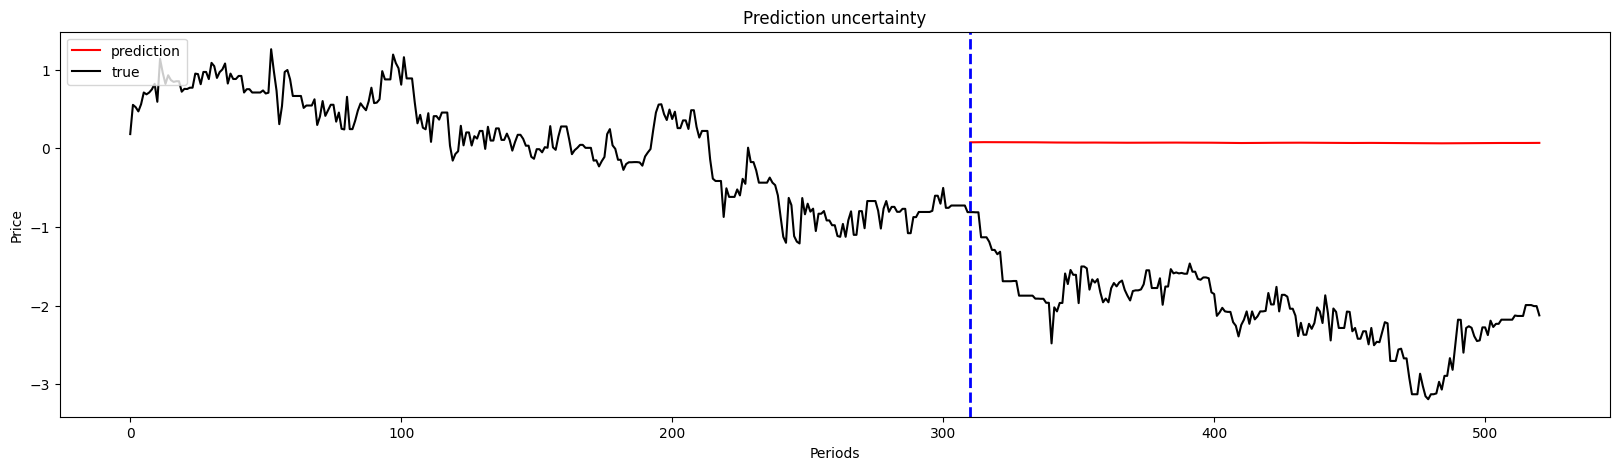

-----------------------------------------------------------------------------------------
| end of epoch   5 | time:  3.82s | valid loss 0.32692 | valid ppl     1.39
-----------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:389: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch   6 |     6/   33 batches | lr 0.000044 | 77.25 ms | loss 0.56155 | ppl     1.75
| epoch   6 |    12/   33 batches | lr 0.000044 | 65.01 ms | loss 0.24846 | ppl     1.28
| epoch   6 |    18/   33 batches | lr 0.000044 | 63.76 ms | loss 0.13930 | ppl     1.15
| epoch   6 |    24/   33 batches | lr 0.000044 | 63.83 ms | loss 0.08743 | ppl     1.09
| epoch   6 |    30/   33 batches | lr 0.000044 | 64.61 ms | loss 0.23485 | ppl     1.26
torch.Size([521, 4]) torch.Size([521, 4])


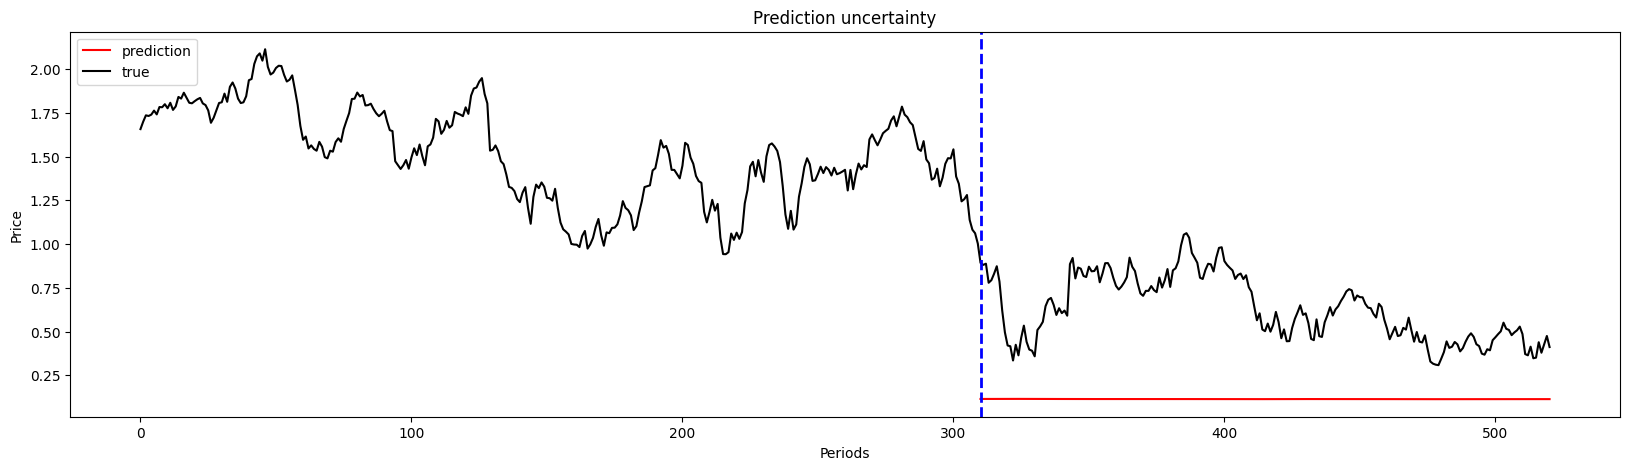

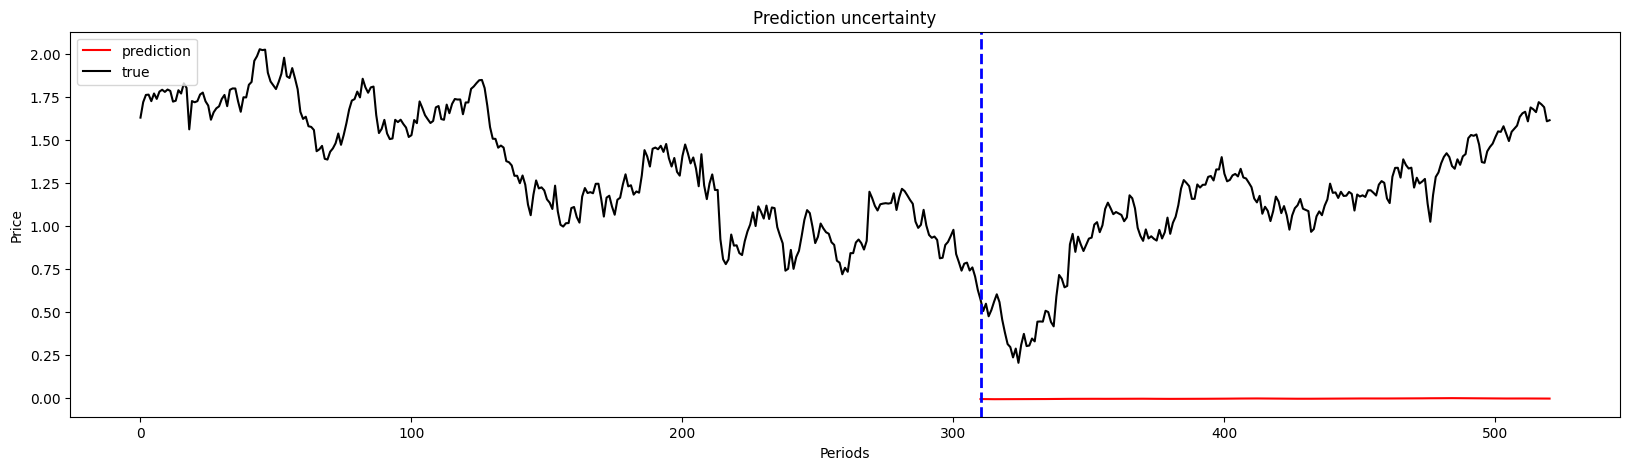

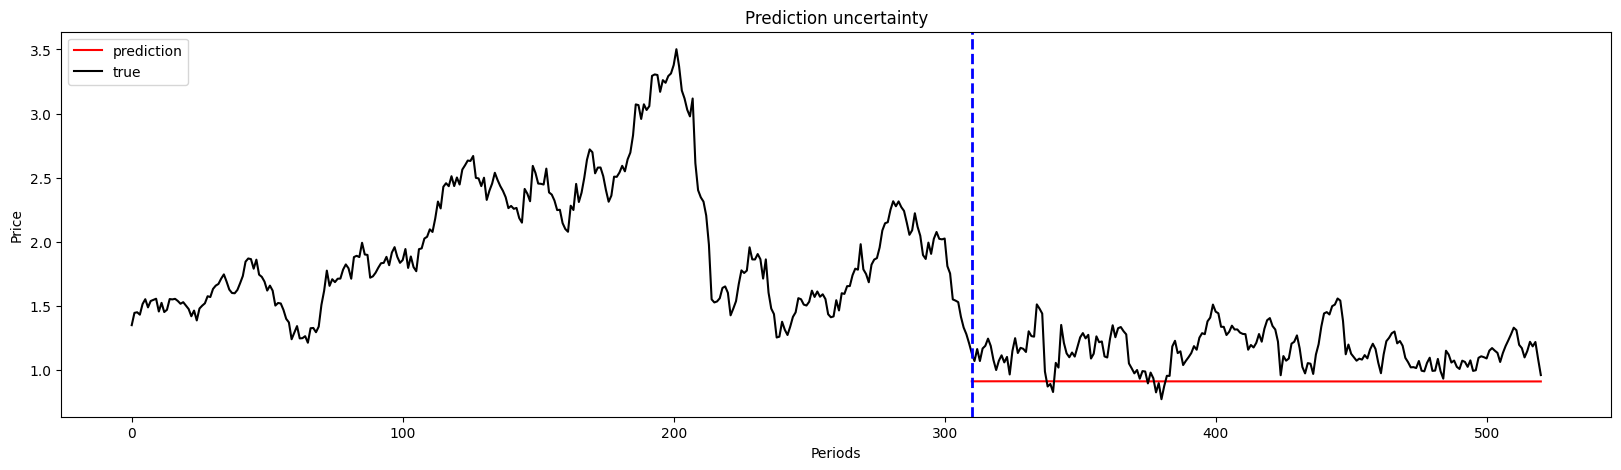

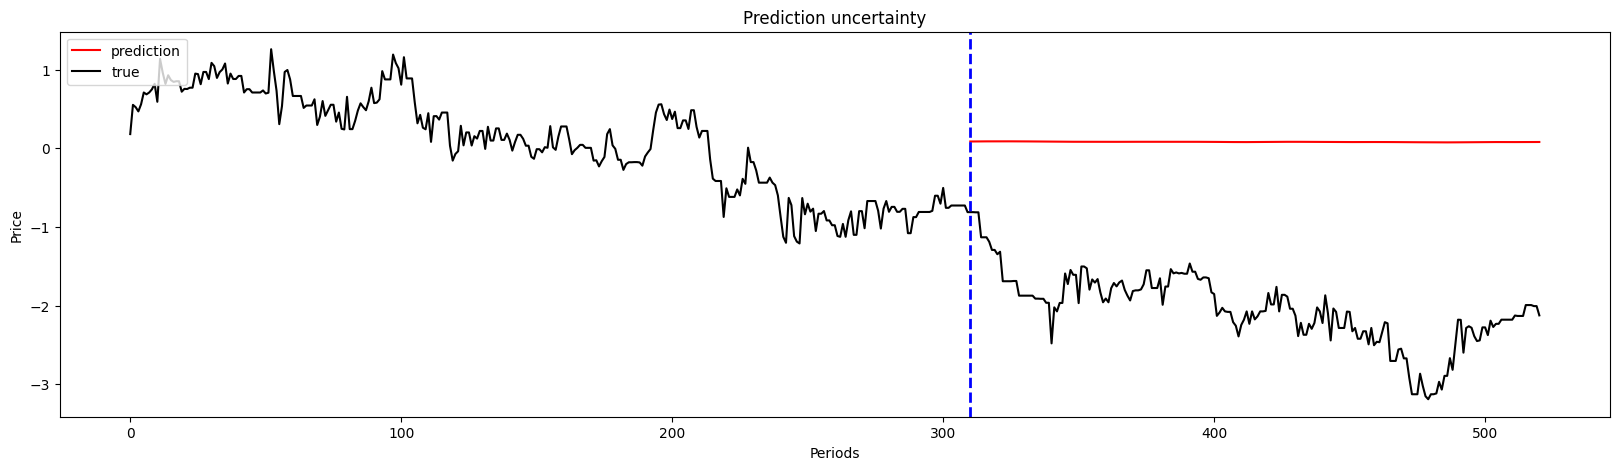

-----------------------------------------------------------------------------------------
| end of epoch   6 | time:  4.06s | valid loss 0.33219 | valid ppl     1.39
-----------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:389: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch   7 |     6/   33 batches | lr 0.000043 | 89.54 ms | loss 0.55448 | ppl     1.74
| epoch   7 |    12/   33 batches | lr 0.000043 | 70.52 ms | loss 0.24460 | ppl     1.28
| epoch   7 |    18/   33 batches | lr 0.000043 | 70.17 ms | loss 0.13477 | ppl     1.14
| epoch   7 |    24/   33 batches | lr 0.000043 | 64.12 ms | loss 0.08519 | ppl     1.09
| epoch   7 |    30/   33 batches | lr 0.000043 | 62.46 ms | loss 0.23622 | ppl     1.27
torch.Size([521, 4]) torch.Size([521, 4])


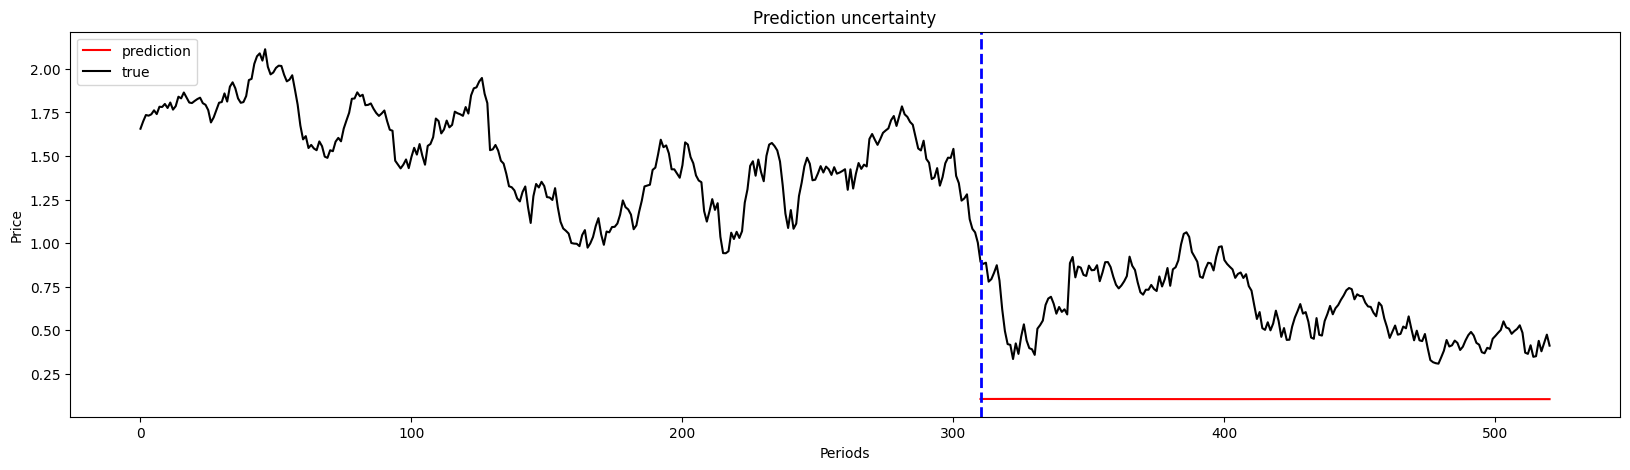

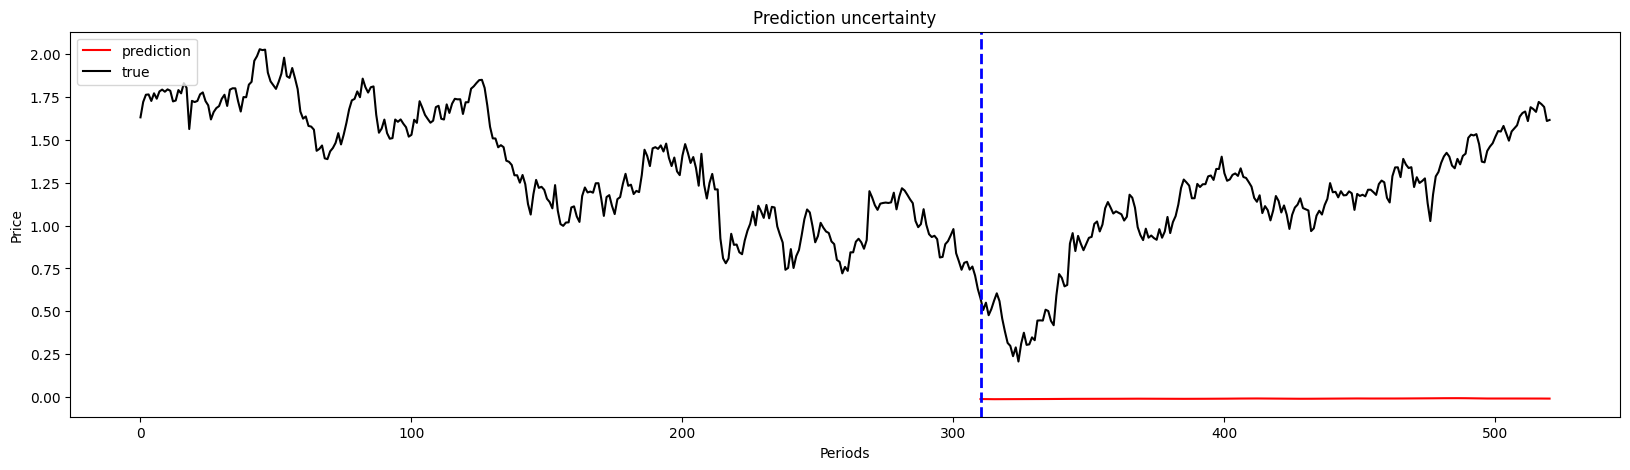

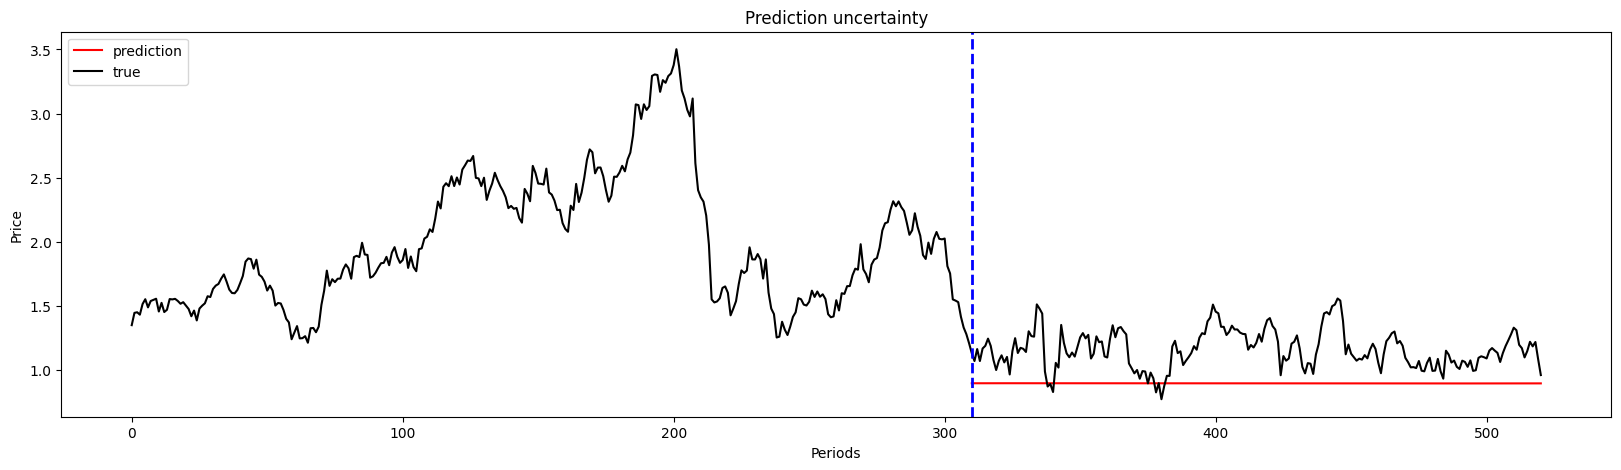

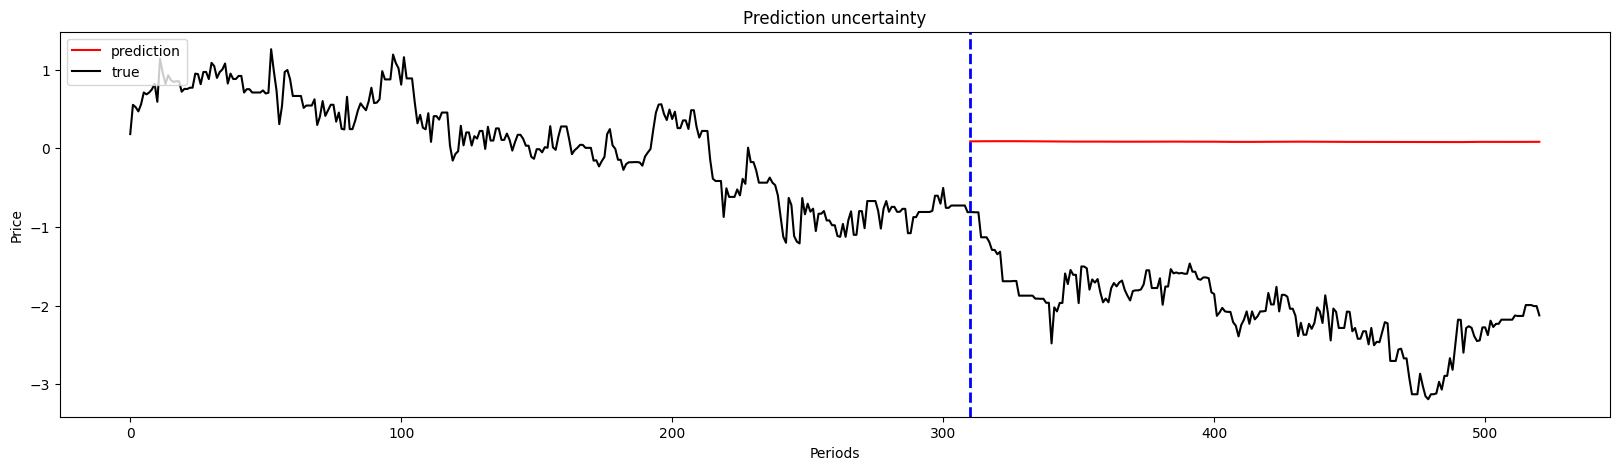

-----------------------------------------------------------------------------------------
| end of epoch   7 | time:  3.97s | valid loss 0.33649 | valid ppl     1.40
-----------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:389: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch   8 |     6/   33 batches | lr 0.000043 | 77.54 ms | loss 0.54547 | ppl     1.73
| epoch   8 |    12/   33 batches | lr 0.000043 | 66.74 ms | loss 0.23910 | ppl     1.27
| epoch   8 |    18/   33 batches | lr 0.000043 | 64.30 ms | loss 0.13344 | ppl     1.14
| epoch   8 |    24/   33 batches | lr 0.000043 | 62.42 ms | loss 0.08318 | ppl     1.09
| epoch   8 |    30/   33 batches | lr 0.000043 | 64.07 ms | loss 0.23759 | ppl     1.27
torch.Size([521, 4]) torch.Size([521, 4])


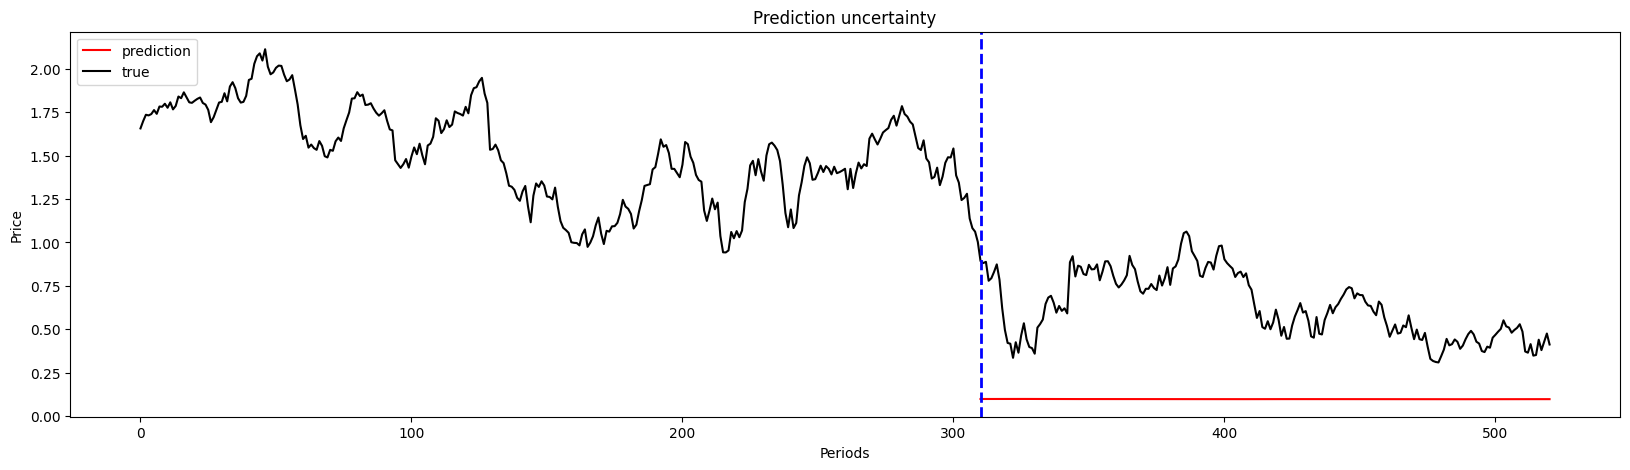

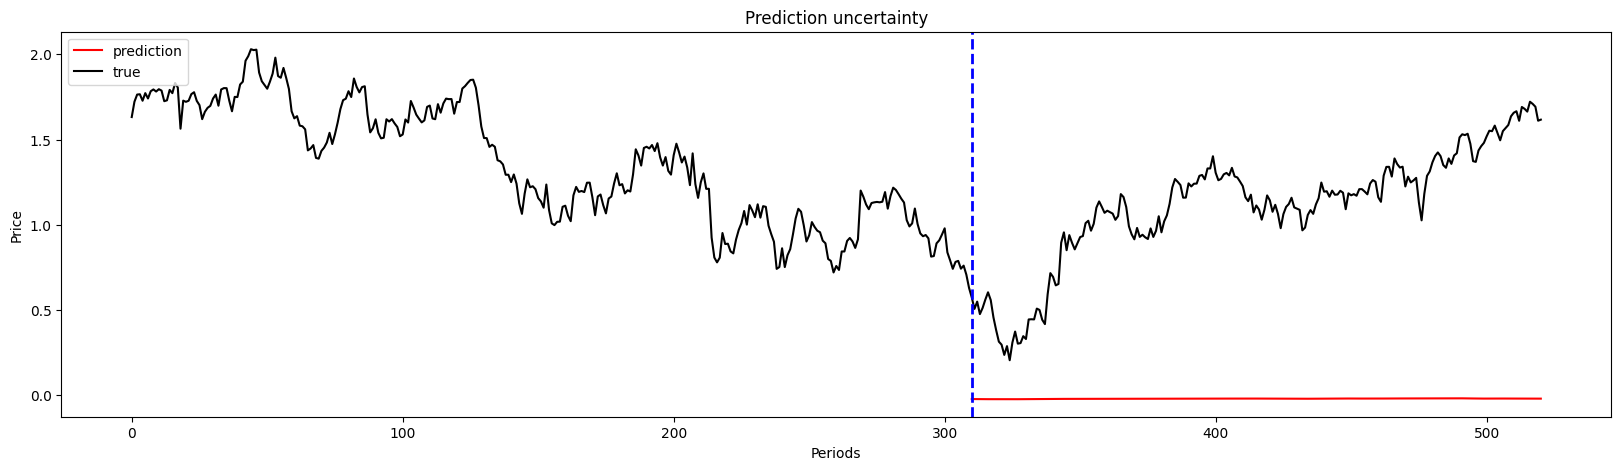

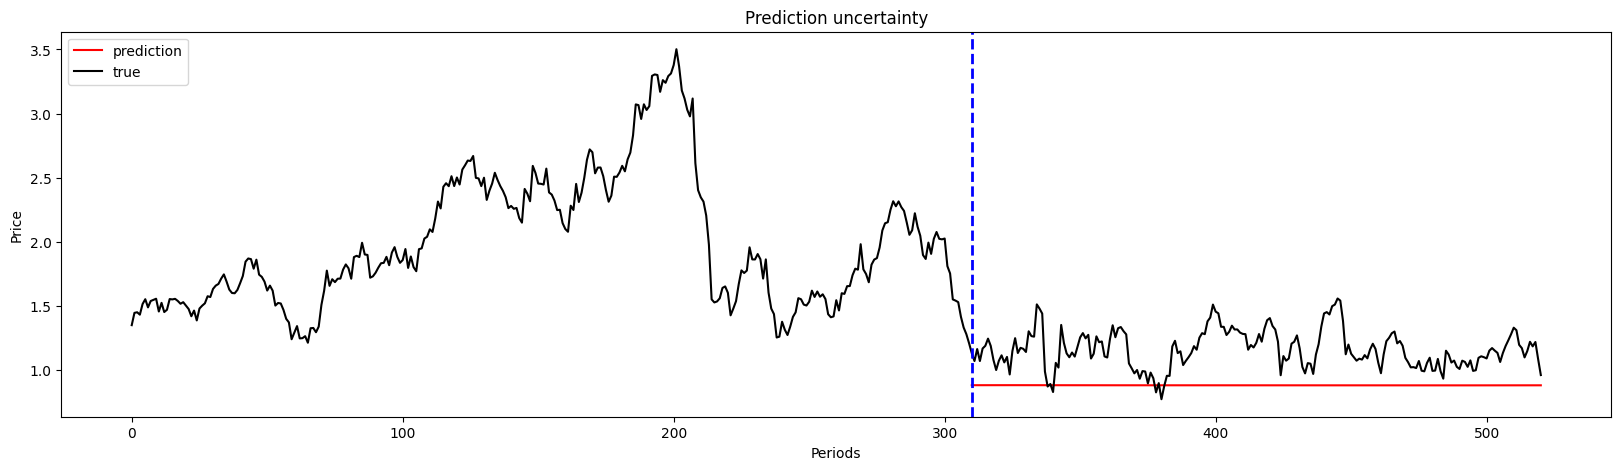

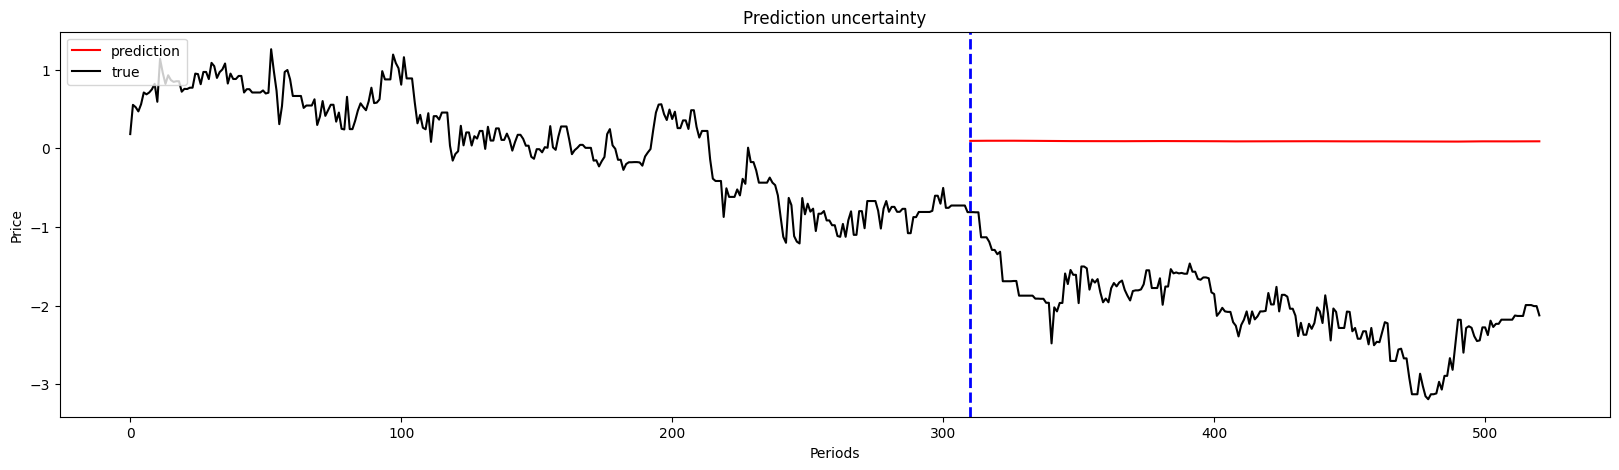

-----------------------------------------------------------------------------------------
| end of epoch   8 | time:  3.80s | valid loss 0.34080 | valid ppl     1.41
-----------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:389: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch   9 |     6/   33 batches | lr 0.000042 | 72.95 ms | loss 0.53849 | ppl     1.71
| epoch   9 |    12/   33 batches | lr 0.000042 | 64.36 ms | loss 0.23522 | ppl     1.27
| epoch   9 |    18/   33 batches | lr 0.000042 | 64.13 ms | loss 0.12993 | ppl     1.14
| epoch   9 |    24/   33 batches | lr 0.000042 | 63.19 ms | loss 0.08102 | ppl     1.08
| epoch   9 |    30/   33 batches | lr 0.000042 | 63.50 ms | loss 0.23814 | ppl     1.27
torch.Size([521, 4]) torch.Size([521, 4])


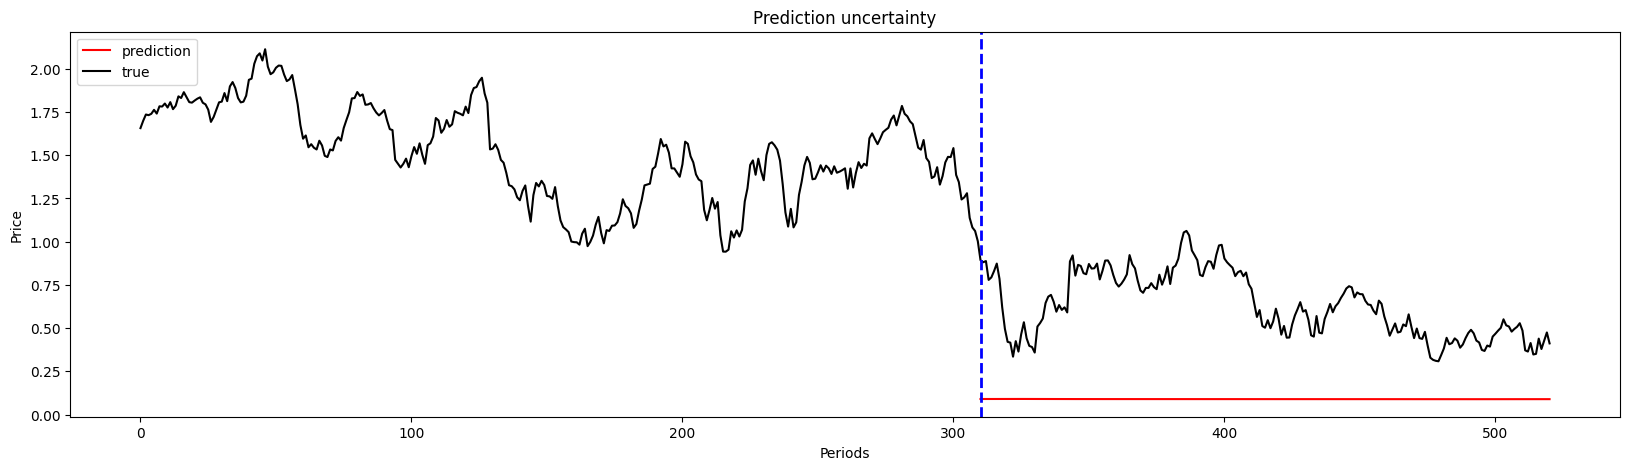

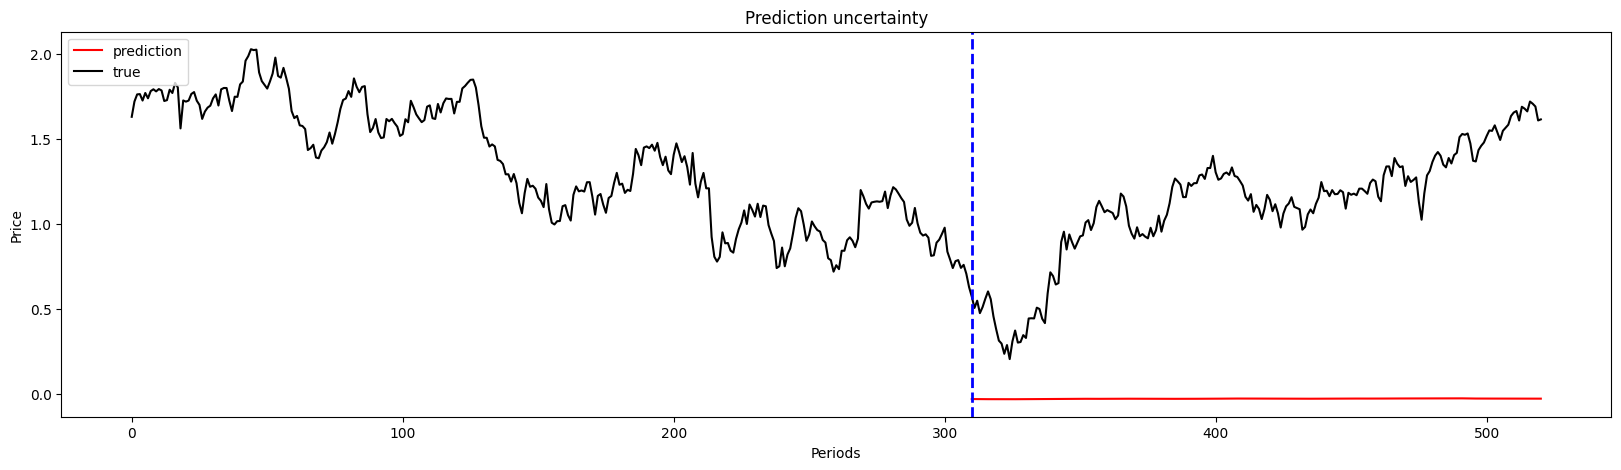

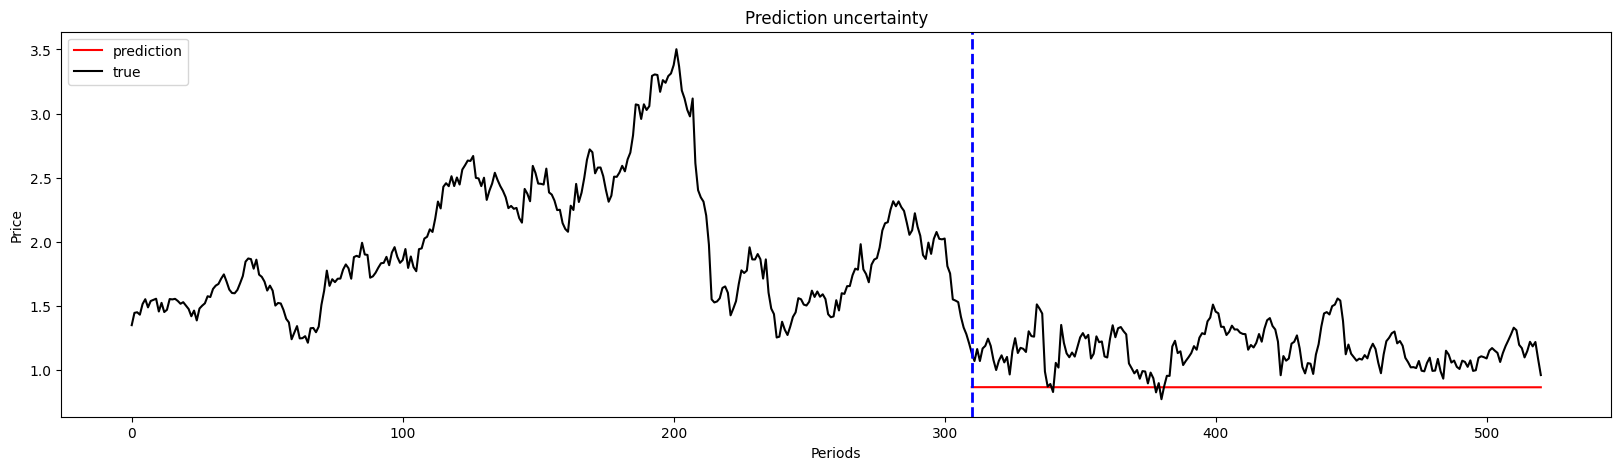

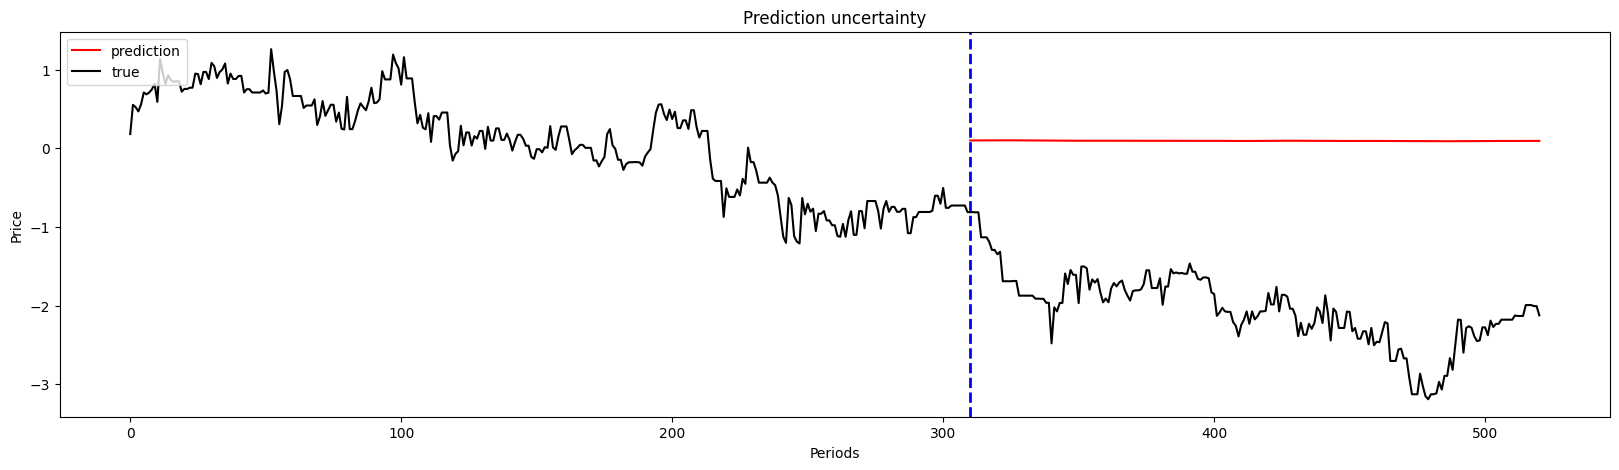

-----------------------------------------------------------------------------------------
| end of epoch   9 | time:  4.01s | valid loss 0.34482 | valid ppl     1.41
-----------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:389: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  10 |     6/   33 batches | lr 0.000041 | 85.45 ms | loss 0.53278 | ppl     1.70
| epoch  10 |    12/   33 batches | lr 0.000041 | 73.52 ms | loss 0.23150 | ppl     1.26
| epoch  10 |    18/   33 batches | lr 0.000041 | 75.97 ms | loss 0.12699 | ppl     1.14
| epoch  10 |    24/   33 batches | lr 0.000041 | 66.12 ms | loss 0.07910 | ppl     1.08
| epoch  10 |    30/   33 batches | lr 0.000041 | 62.40 ms | loss 0.23855 | ppl     1.27
torch.Size([521, 4]) torch.Size([521, 4])


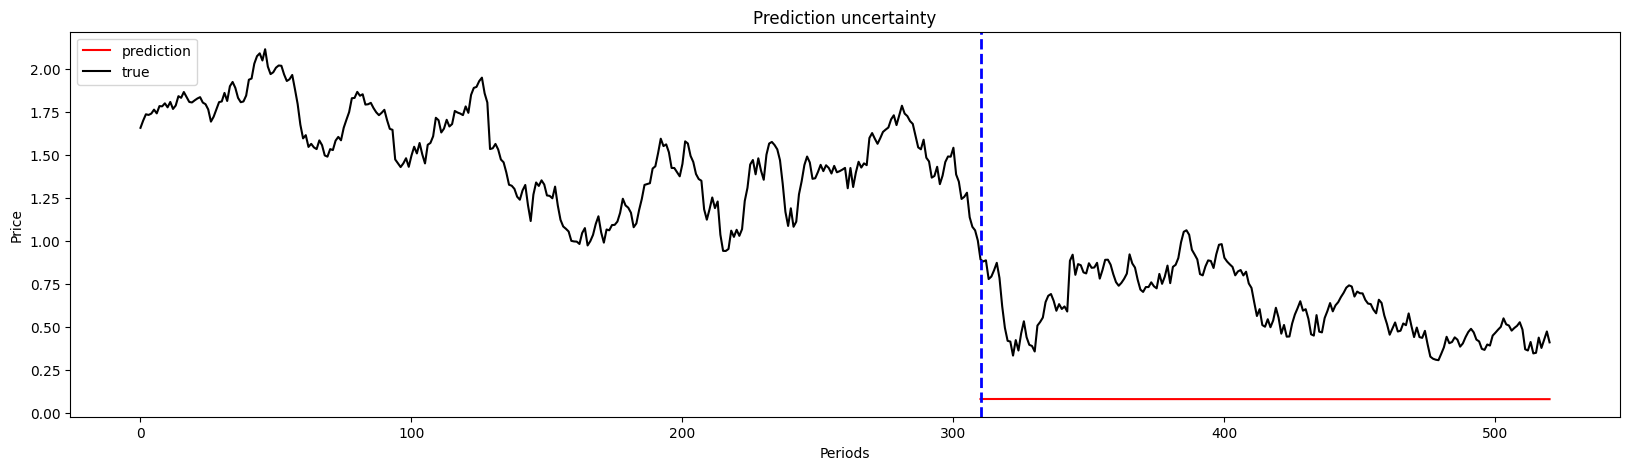

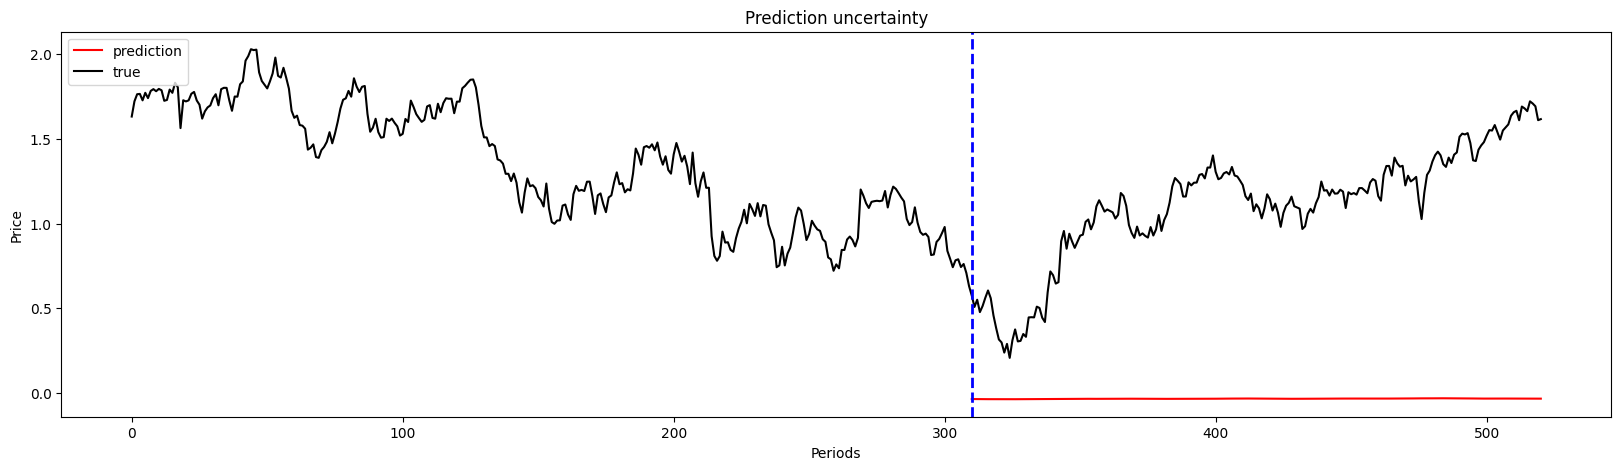

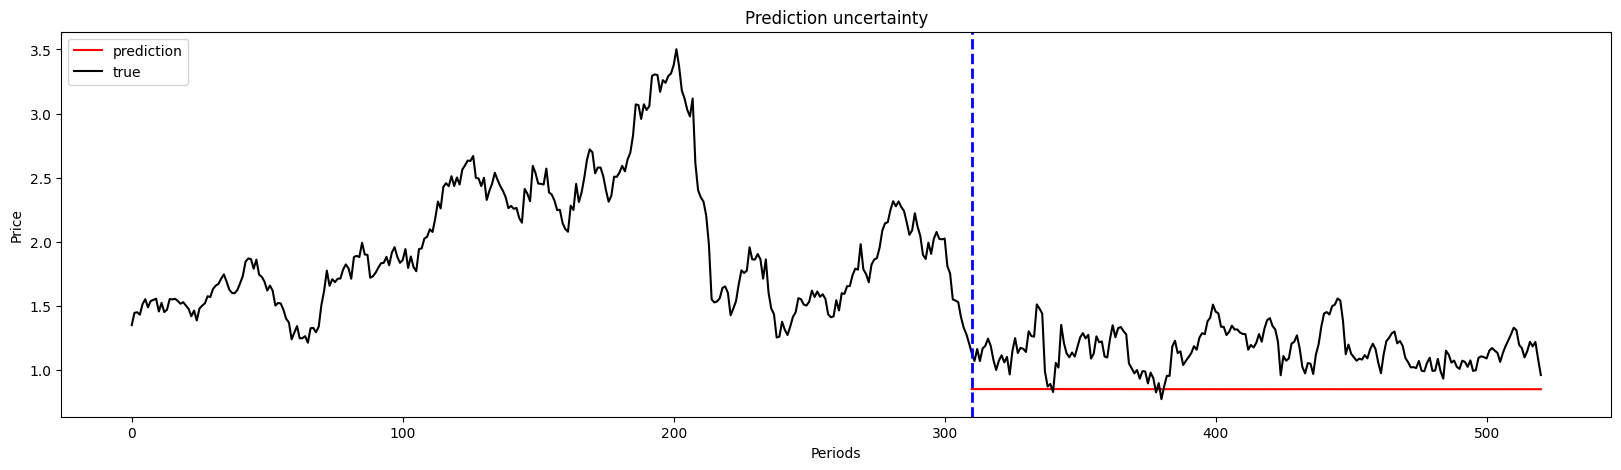

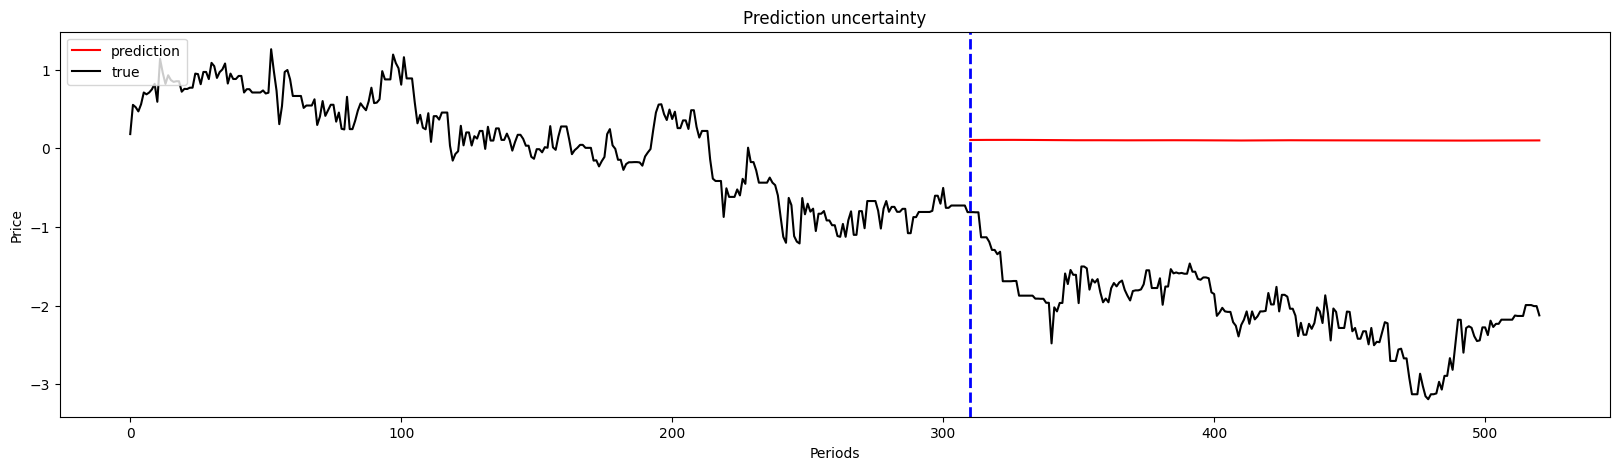

-----------------------------------------------------------------------------------------
| end of epoch  10 | time:  4.32s | valid loss 0.34896 | valid ppl     1.42
-----------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:389: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  11 |     6/   33 batches | lr 0.000040 | 79.48 ms | loss 0.52565 | ppl     1.69
| epoch  11 |    12/   33 batches | lr 0.000040 | 66.52 ms | loss 0.22776 | ppl     1.26
| epoch  11 |    18/   33 batches | lr 0.000040 | 65.61 ms | loss 0.12449 | ppl     1.13
| epoch  11 |    24/   33 batches | lr 0.000040 | 65.99 ms | loss 0.07735 | ppl     1.08
| epoch  11 |    30/   33 batches | lr 0.000040 | 65.75 ms | loss 0.24146 | ppl     1.27
torch.Size([521, 4]) torch.Size([521, 4])


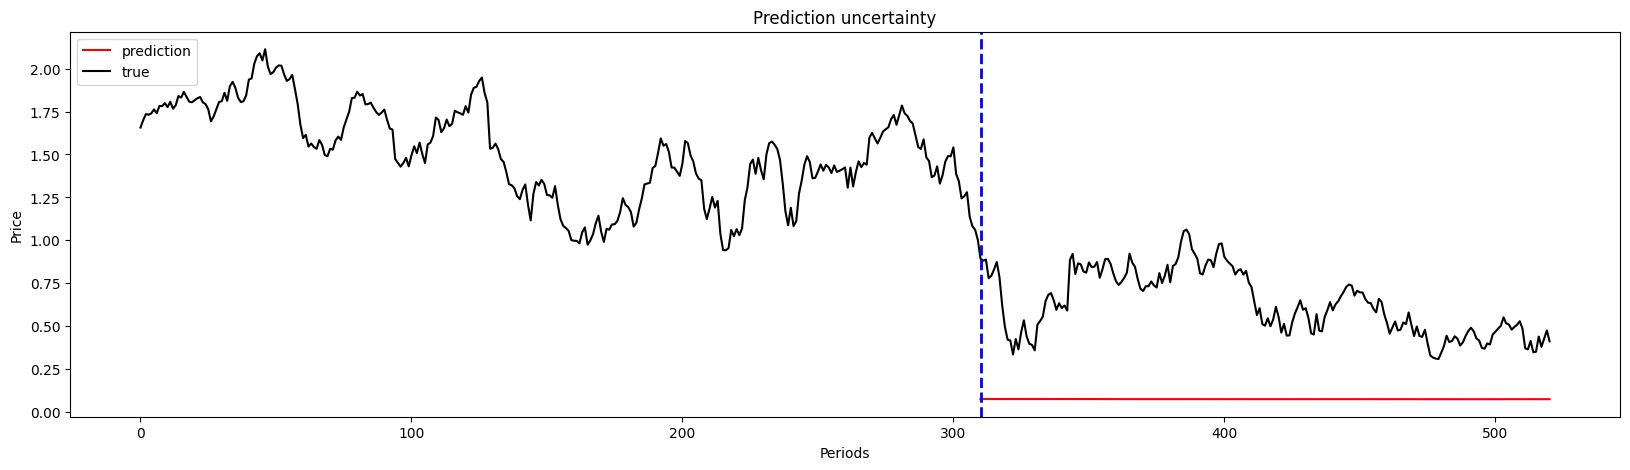

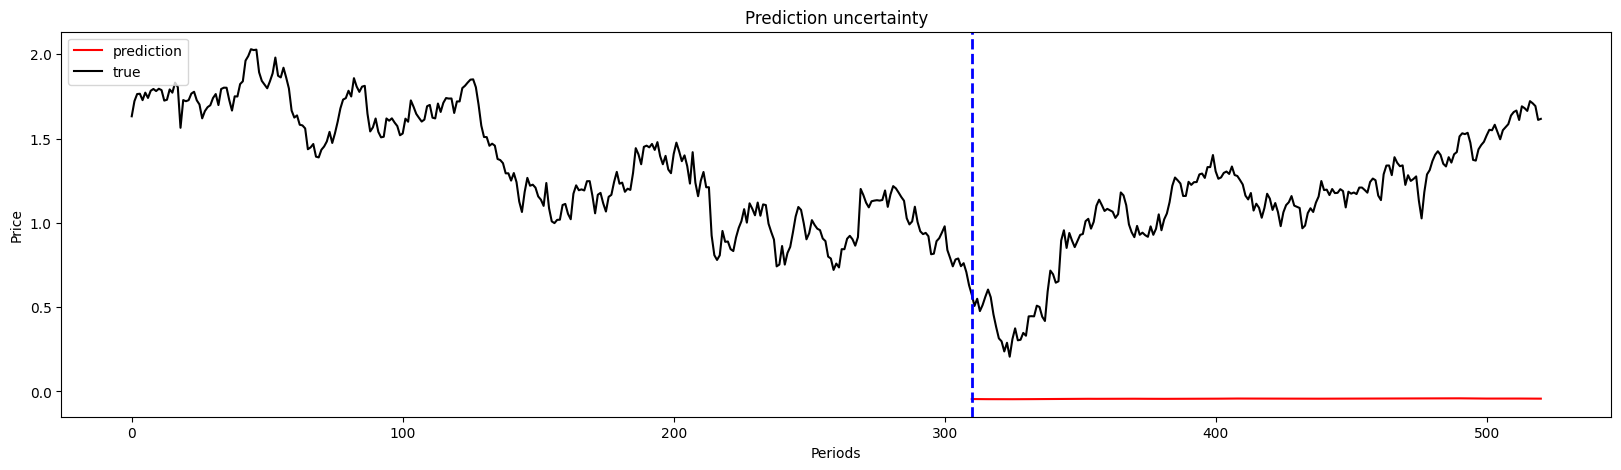

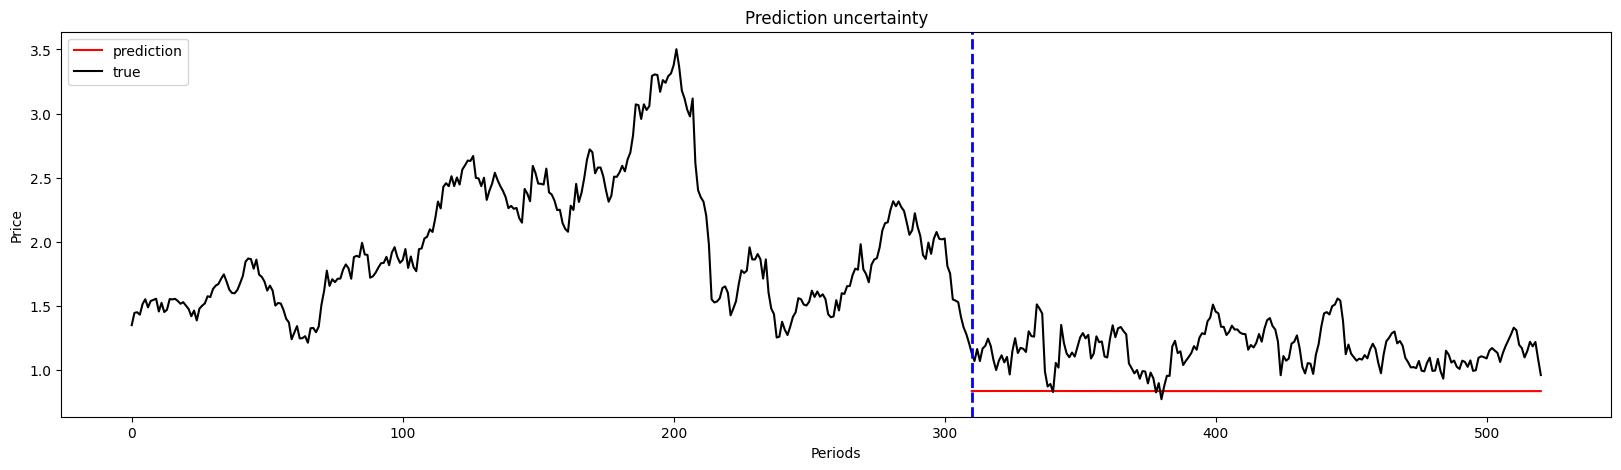

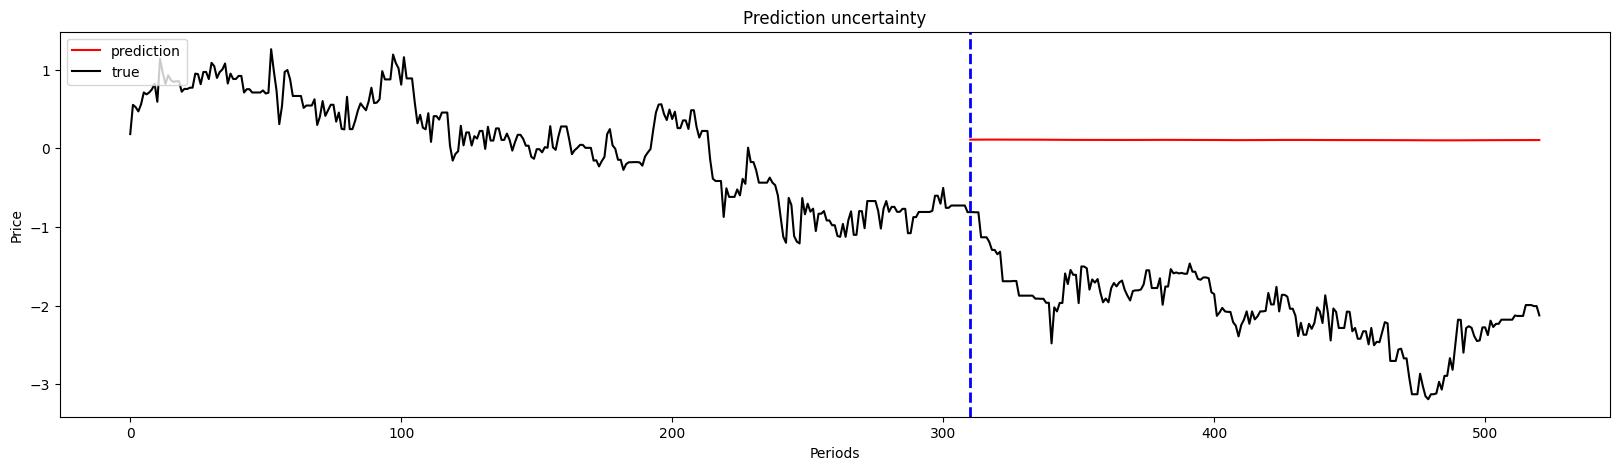

-----------------------------------------------------------------------------------------
| end of epoch  11 | time:  3.86s | valid loss 0.35308 | valid ppl     1.42
-----------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:389: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  12 |     6/   33 batches | lr 0.000039 | 74.76 ms | loss 0.51958 | ppl     1.68
| epoch  12 |    12/   33 batches | lr 0.000039 | 67.07 ms | loss 0.22423 | ppl     1.25
| epoch  12 |    18/   33 batches | lr 0.000039 | 64.14 ms | loss 0.12220 | ppl     1.13
| epoch  12 |    24/   33 batches | lr 0.000039 | 64.11 ms | loss 0.07531 | ppl     1.08
| epoch  12 |    30/   33 batches | lr 0.000039 | 64.71 ms | loss 0.24159 | ppl     1.27
torch.Size([521, 4]) torch.Size([521, 4])


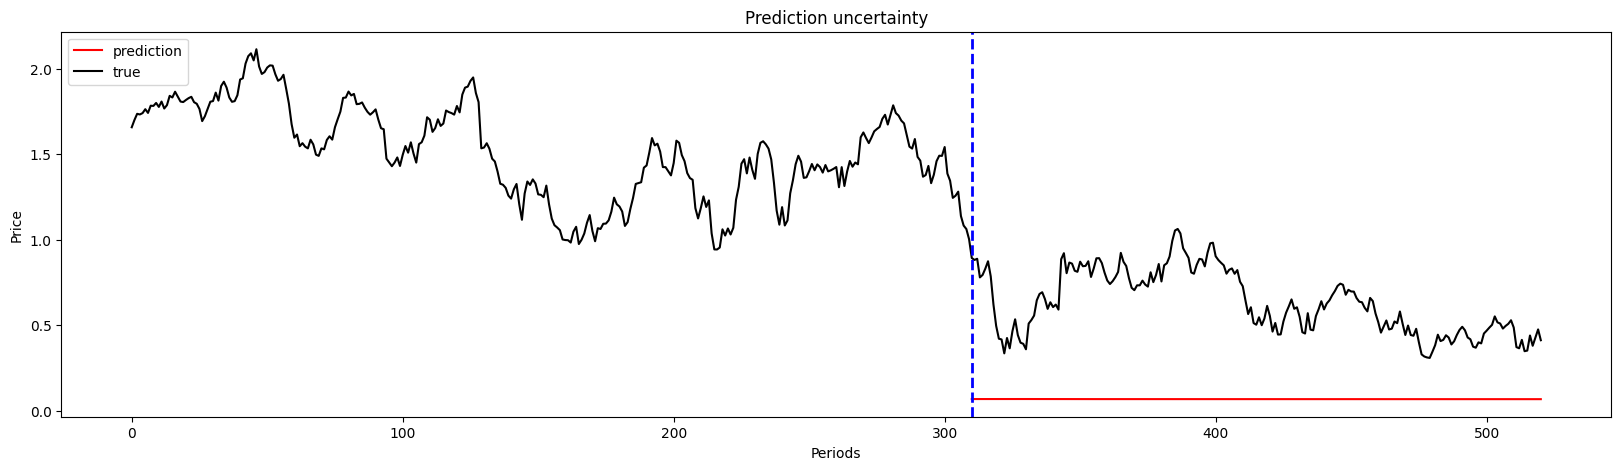

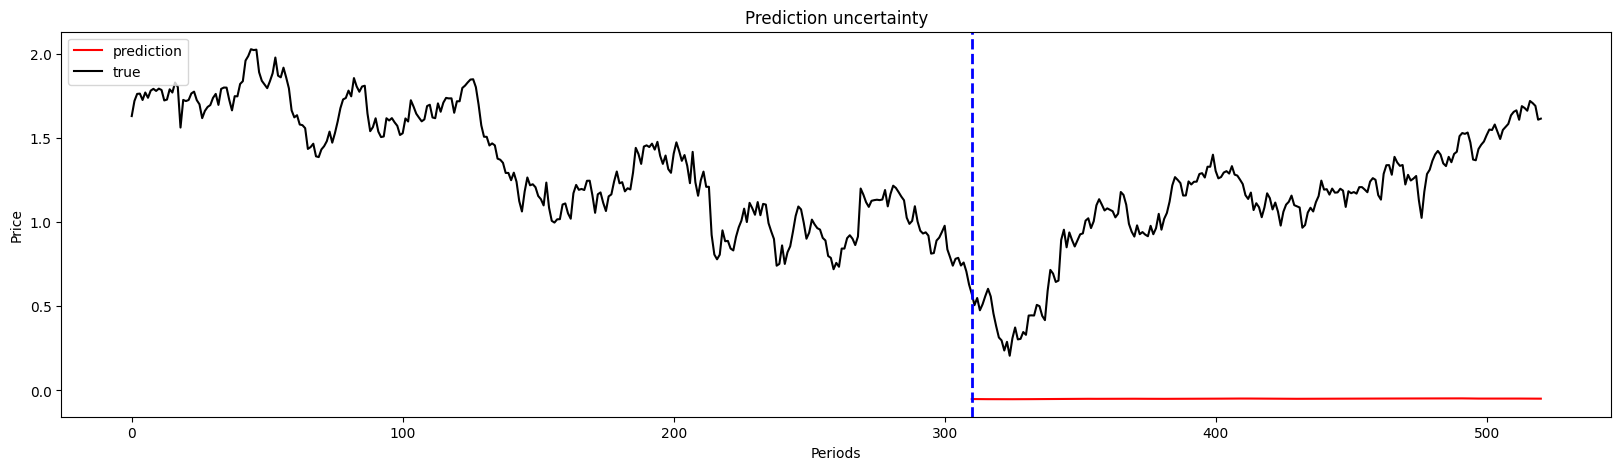

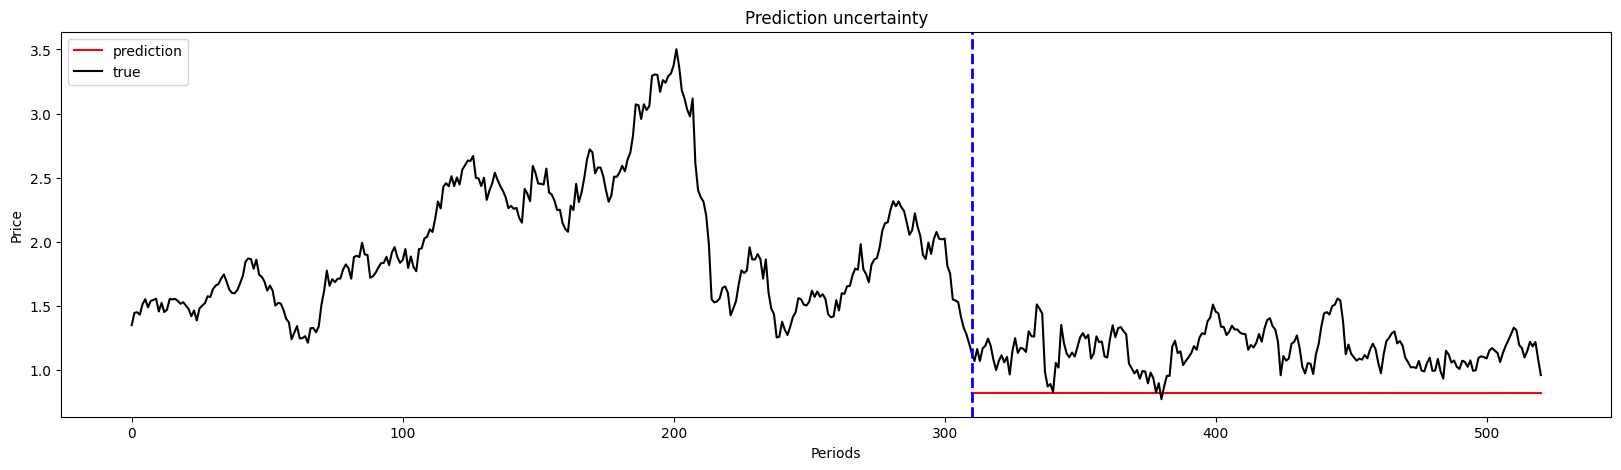

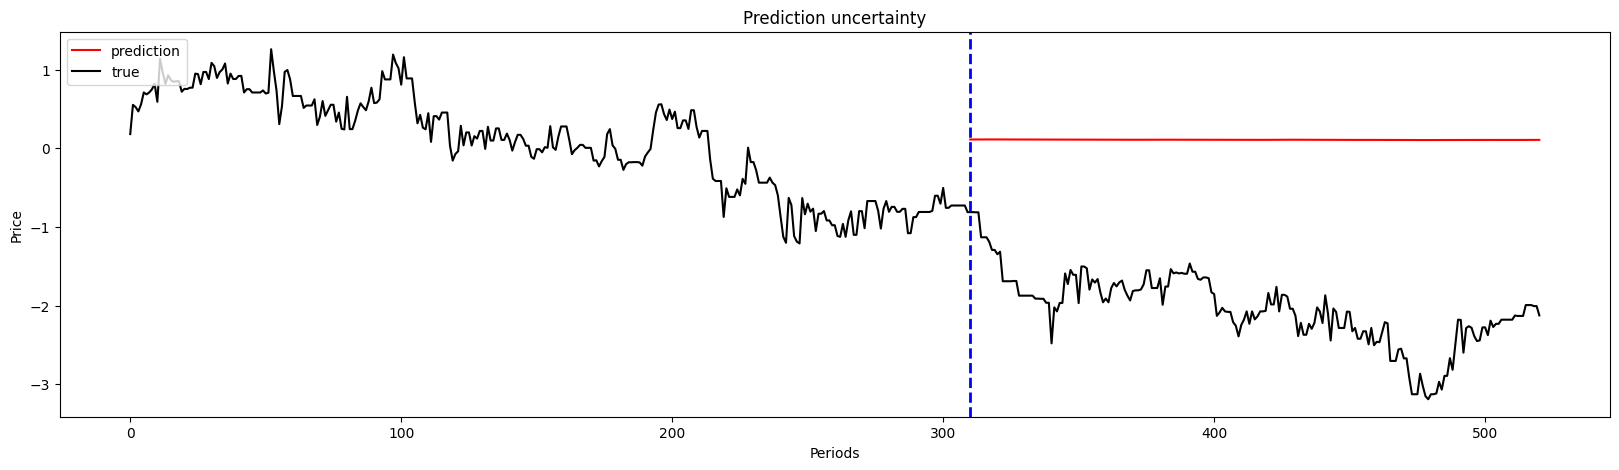

-----------------------------------------------------------------------------------------
| end of epoch  12 | time:  4.02s | valid loss 0.35687 | valid ppl     1.43
-----------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:389: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  13 |     6/   33 batches | lr 0.000038 | 86.86 ms | loss 0.51318 | ppl     1.67
| epoch  13 |    12/   33 batches | lr 0.000038 | 75.17 ms | loss 0.22029 | ppl     1.25
| epoch  13 |    18/   33 batches | lr 0.000038 | 77.69 ms | loss 0.12008 | ppl     1.13
| epoch  13 |    24/   33 batches | lr 0.000038 | 67.37 ms | loss 0.07355 | ppl     1.08
| epoch  13 |    30/   33 batches | lr 0.000038 | 64.39 ms | loss 0.24180 | ppl     1.27
torch.Size([521, 4]) torch.Size([521, 4])


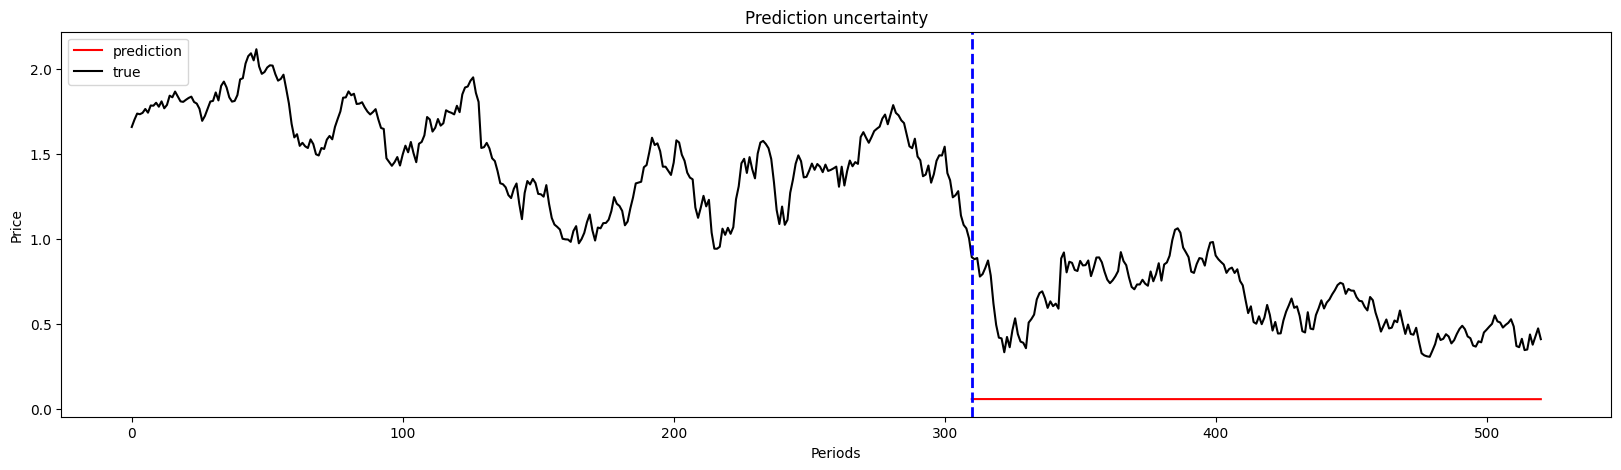

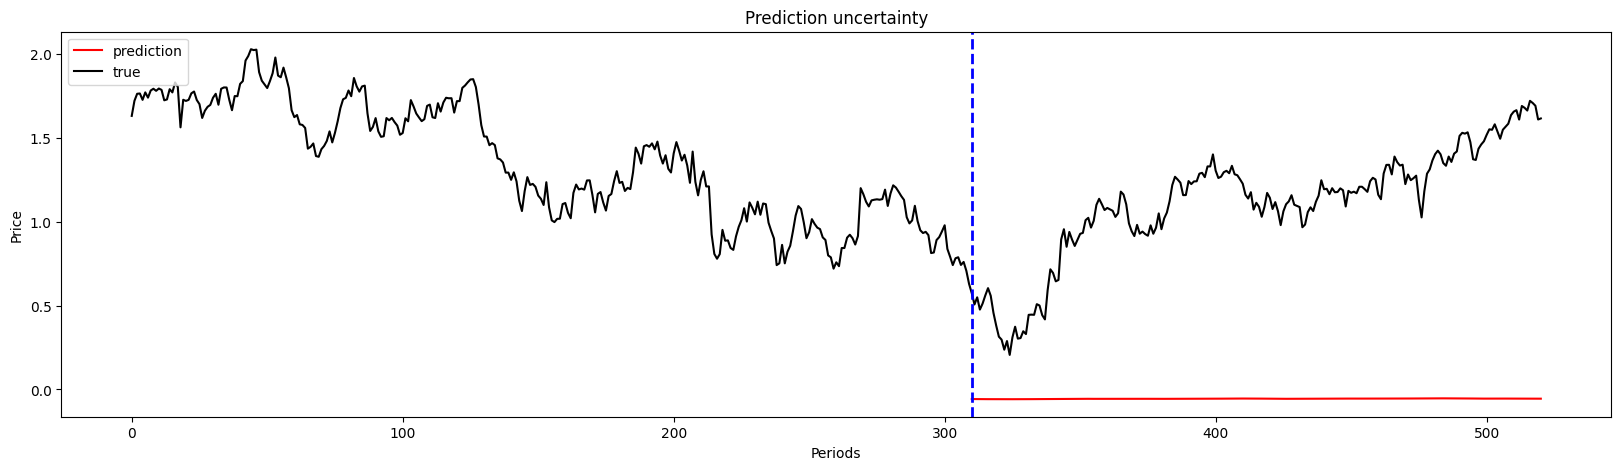

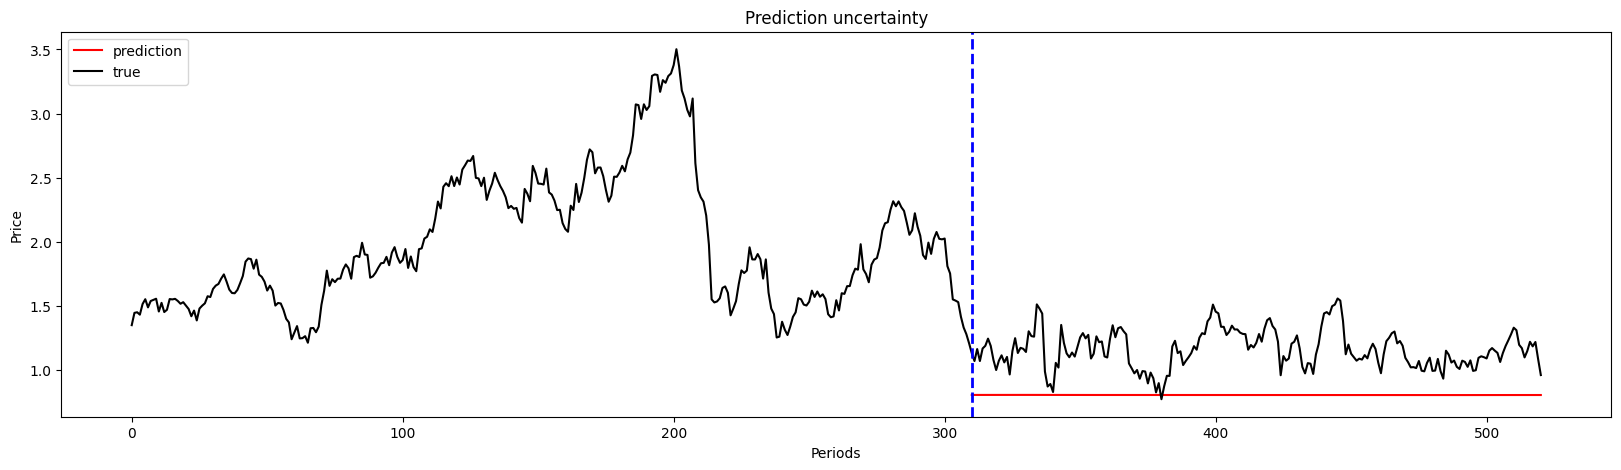

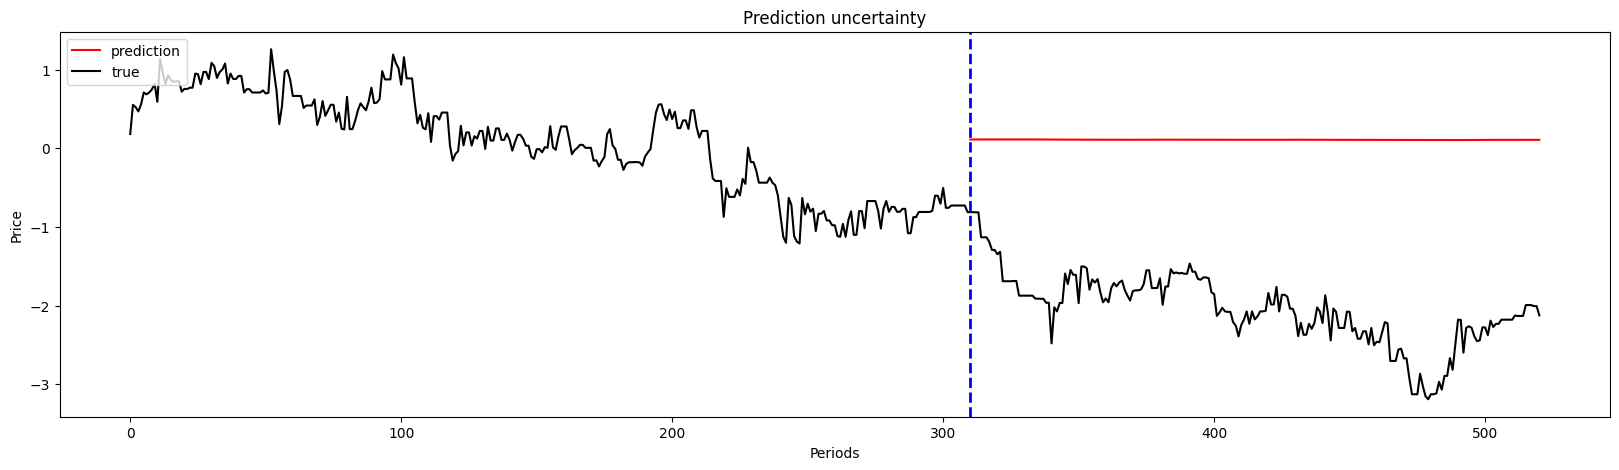

-----------------------------------------------------------------------------------------
| end of epoch  13 | time:  4.02s | valid loss 0.36046 | valid ppl     1.43
-----------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:389: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  14 |     6/   33 batches | lr 0.000038 | 80.04 ms | loss 0.50642 | ppl     1.66
| epoch  14 |    12/   33 batches | lr 0.000038 | 69.45 ms | loss 0.21702 | ppl     1.24
| epoch  14 |    18/   33 batches | lr 0.000038 | 64.26 ms | loss 0.11804 | ppl     1.13
| epoch  14 |    24/   33 batches | lr 0.000038 | 65.91 ms | loss 0.07191 | ppl     1.07
| epoch  14 |    30/   33 batches | lr 0.000038 | 65.55 ms | loss 0.24280 | ppl     1.27
torch.Size([521, 4]) torch.Size([521, 4])


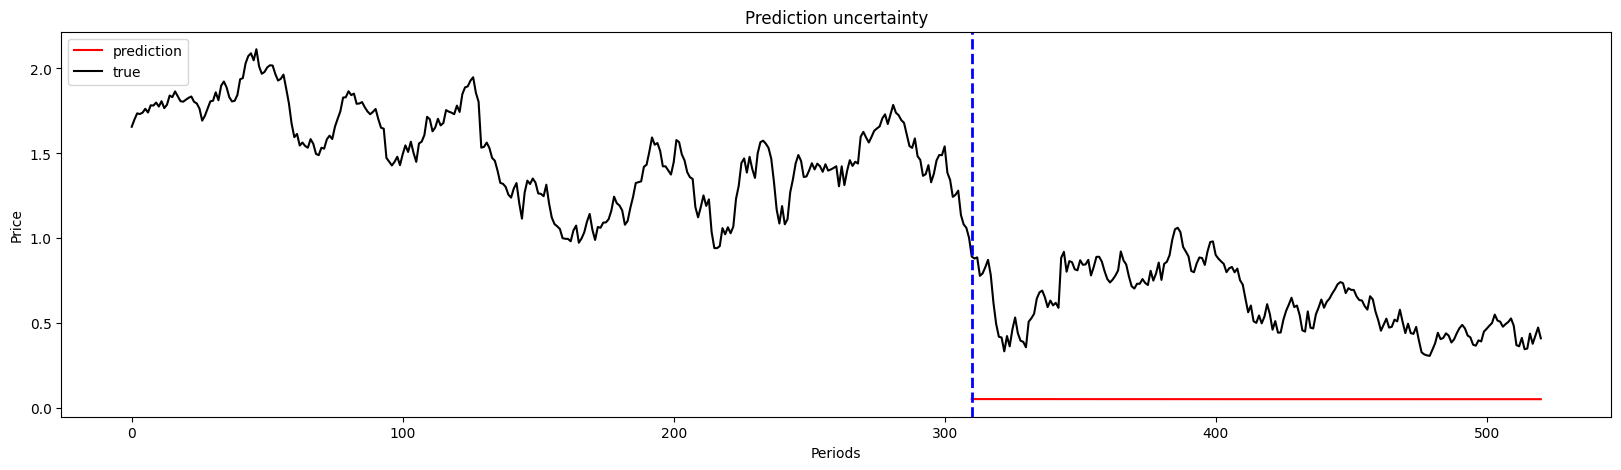

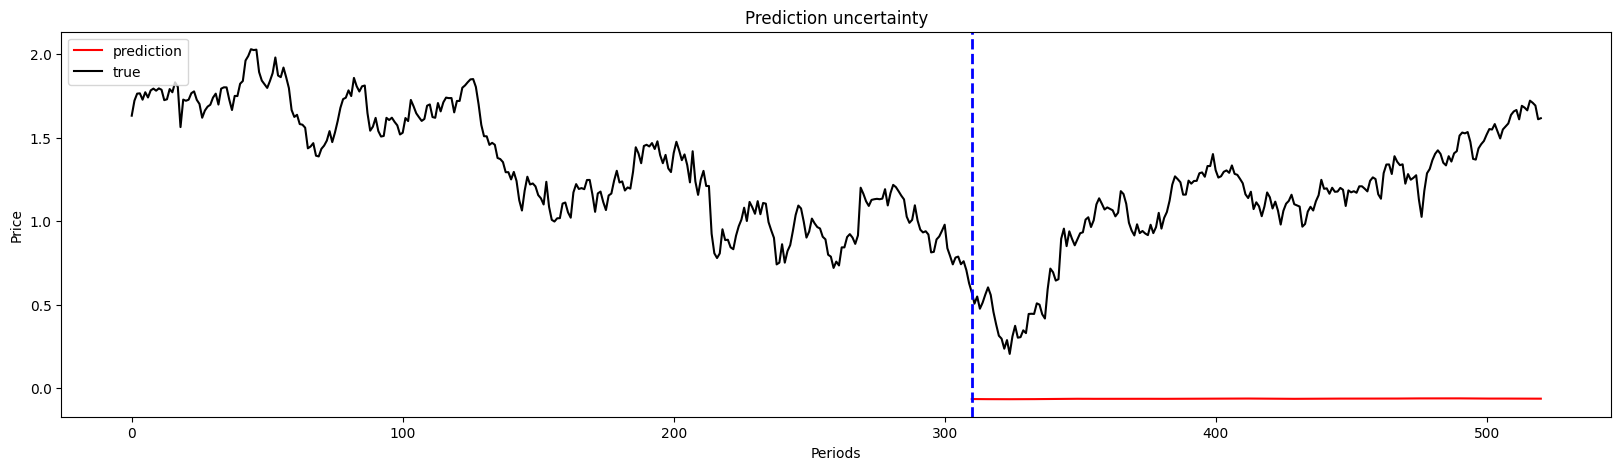

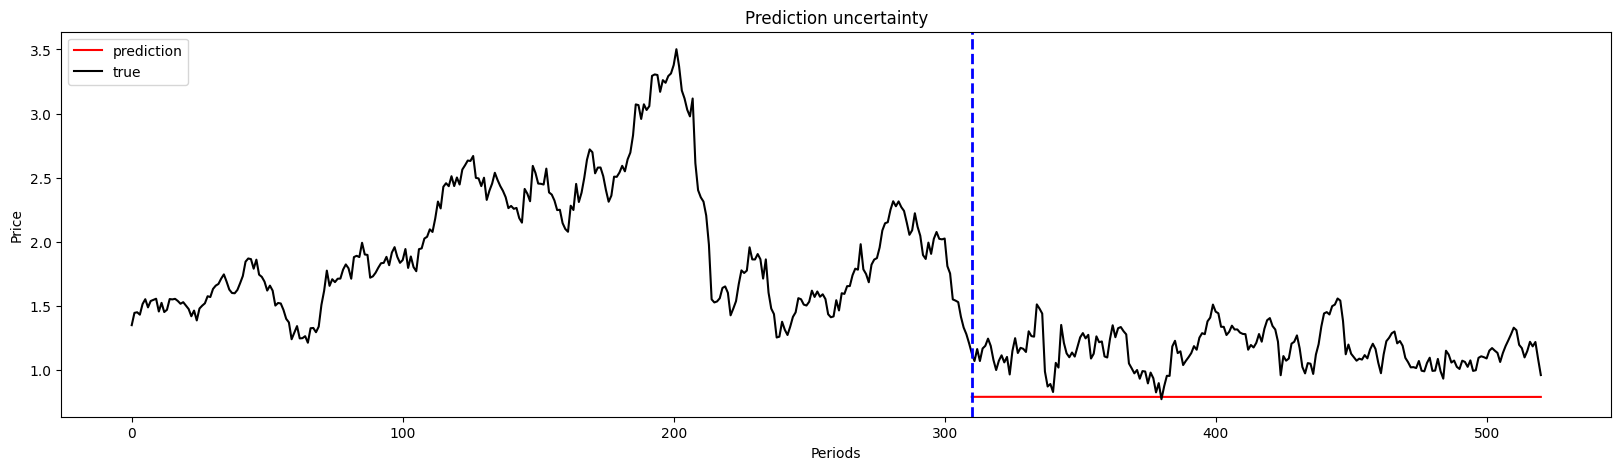

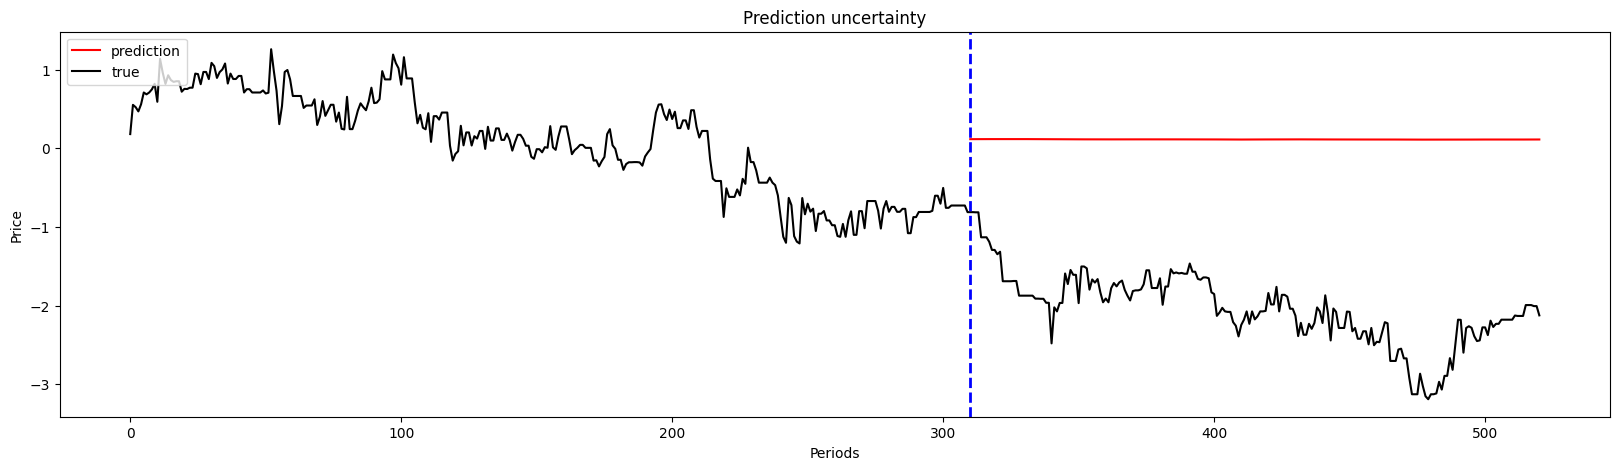

-----------------------------------------------------------------------------------------
| end of epoch  14 | time:  3.97s | valid loss 0.36425 | valid ppl     1.44
-----------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:389: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  15 |     6/   33 batches | lr 0.000037 | 75.47 ms | loss 0.50092 | ppl     1.65
| epoch  15 |    12/   33 batches | lr 0.000037 | 119.78 ms | loss 0.21368 | ppl     1.24
| epoch  15 |    18/   33 batches | lr 0.000037 | 73.12 ms | loss 0.11504 | ppl     1.12
| epoch  15 |    24/   33 batches | lr 0.000037 | 126.25 ms | loss 0.07032 | ppl     1.07
| epoch  15 |    30/   33 batches | lr 0.000037 | 62.92 ms | loss 0.24354 | ppl     1.28
torch.Size([521, 4]) torch.Size([521, 4])


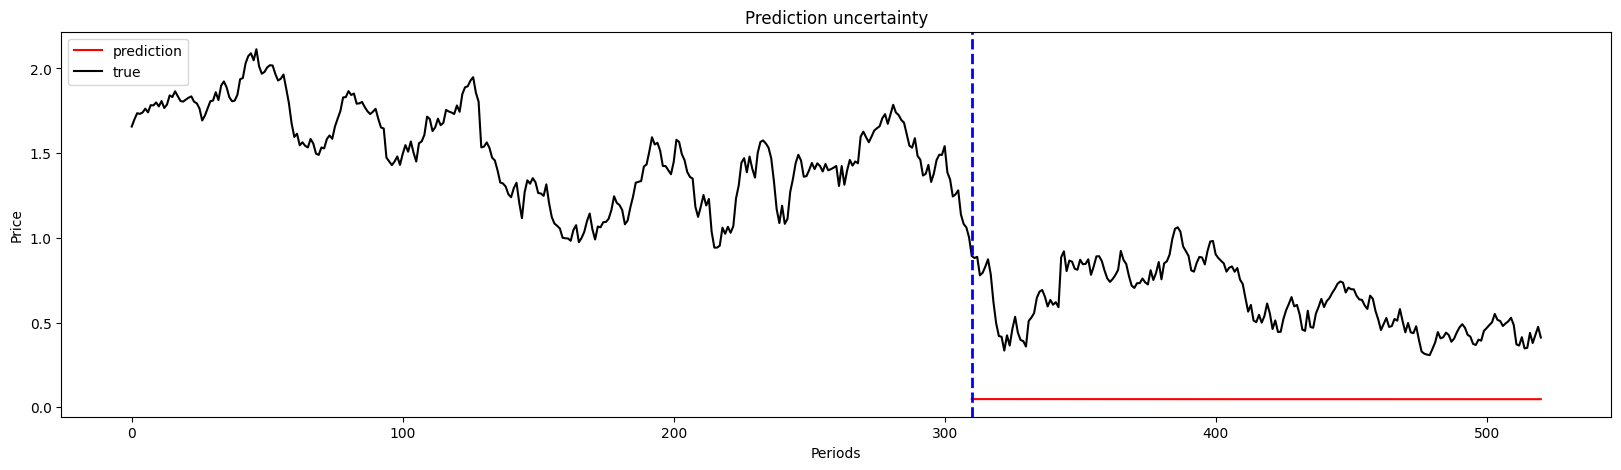

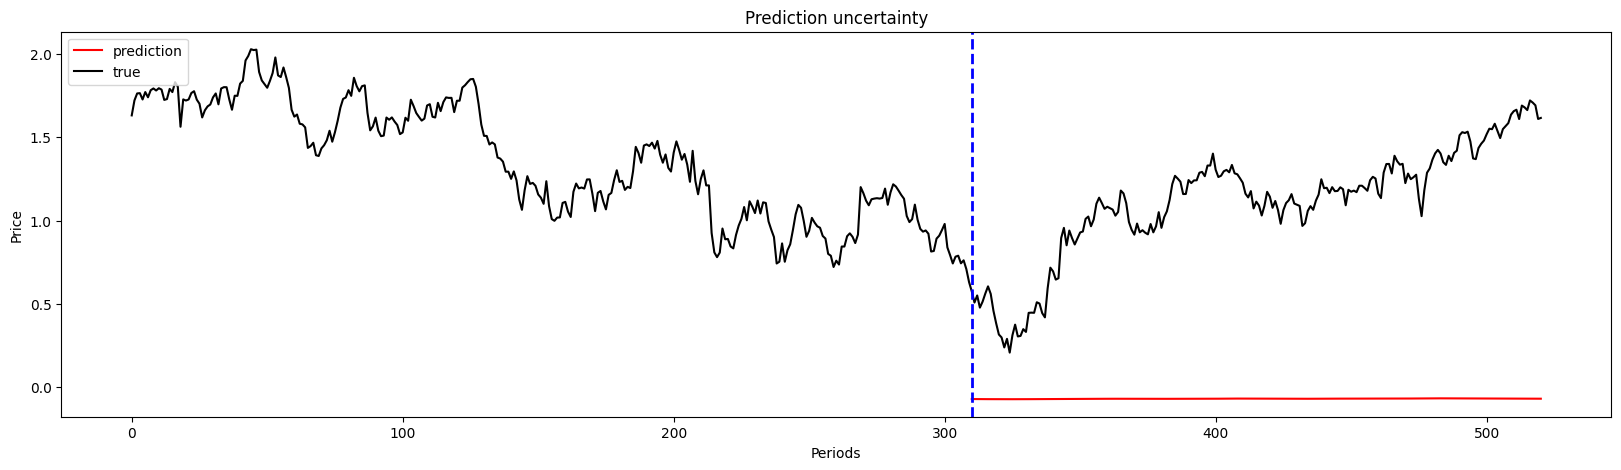

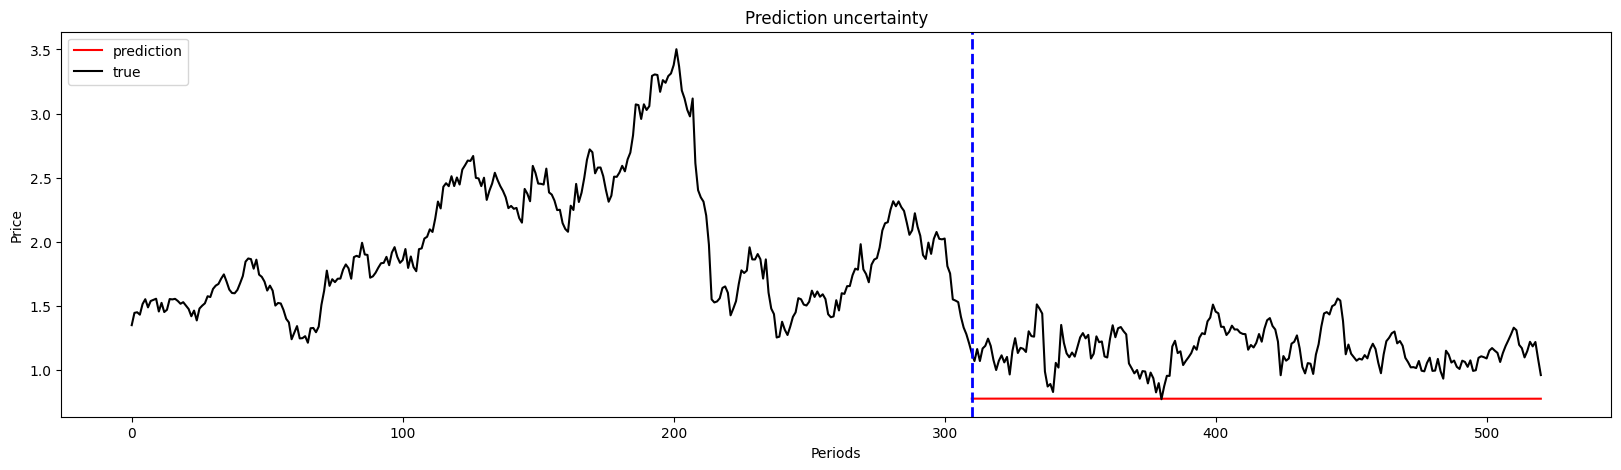

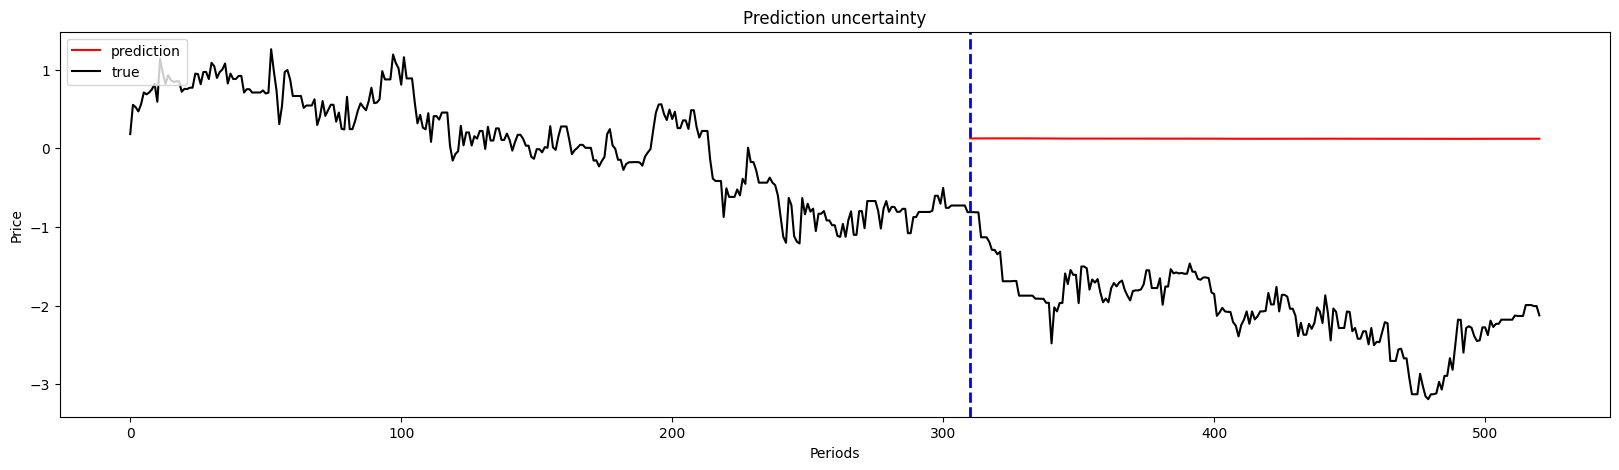

-----------------------------------------------------------------------------------------
| end of epoch  15 | time:  5.52s | valid loss 0.36848 | valid ppl     1.45
-----------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:389: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  16 |     6/   33 batches | lr 0.000036 | 81.79 ms | loss 0.49549 | ppl     1.64
| epoch  16 |    12/   33 batches | lr 0.000036 | 65.69 ms | loss 0.20981 | ppl     1.23
| epoch  16 |    18/   33 batches | lr 0.000036 | 64.04 ms | loss 0.11339 | ppl     1.12
| epoch  16 |    24/   33 batches | lr 0.000036 | 66.12 ms | loss 0.06854 | ppl     1.07
| epoch  16 |    30/   33 batches | lr 0.000036 | 65.04 ms | loss 0.24459 | ppl     1.28
torch.Size([521, 4]) torch.Size([521, 4])


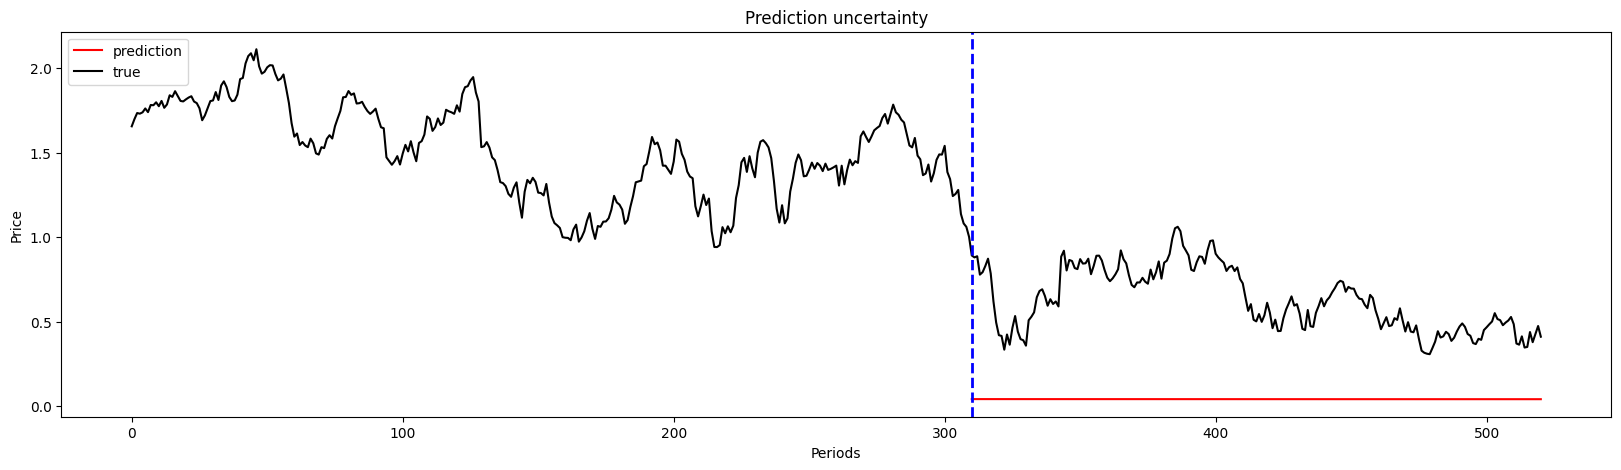

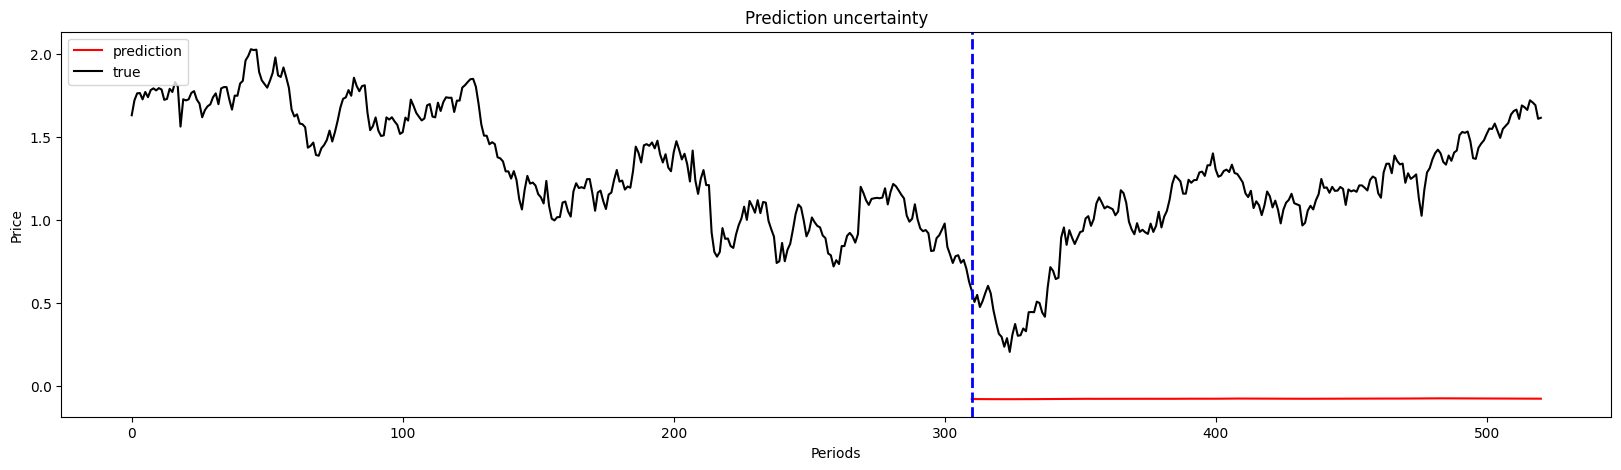

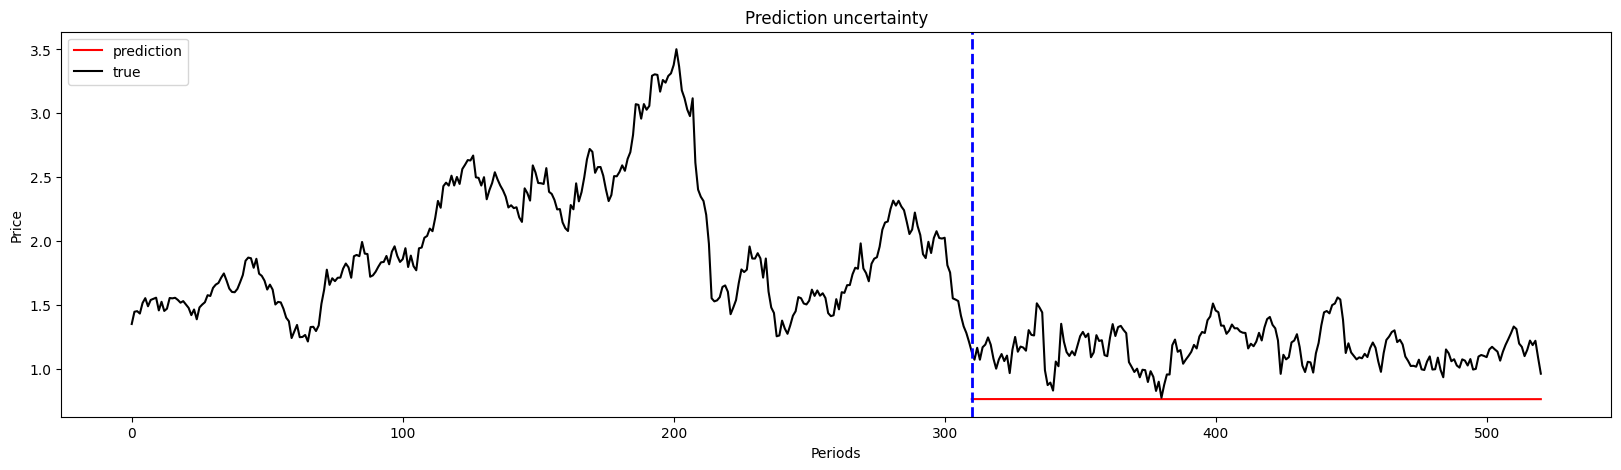

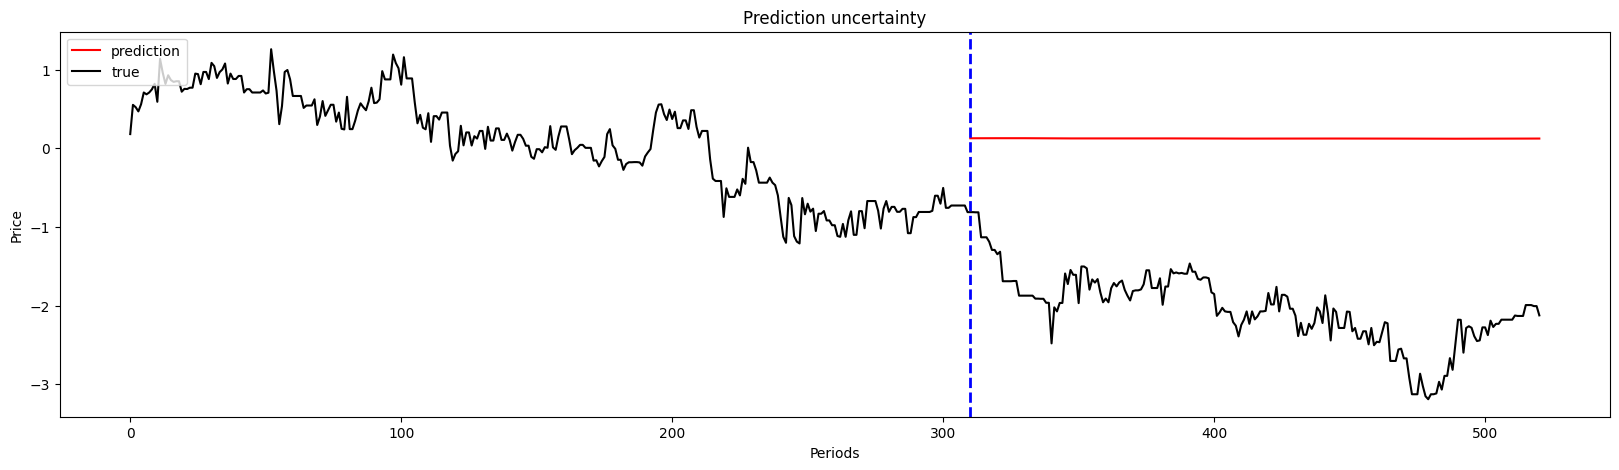

-----------------------------------------------------------------------------------------
| end of epoch  16 | time:  3.96s | valid loss 0.37178 | valid ppl     1.45
-----------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:389: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  17 |     6/   33 batches | lr 0.000035 | 76.80 ms | loss 0.48997 | ppl     1.63
| epoch  17 |    12/   33 batches | lr 0.000035 | 67.64 ms | loss 0.20677 | ppl     1.23
| epoch  17 |    18/   33 batches | lr 0.000035 | 63.97 ms | loss 0.11147 | ppl     1.12
| epoch  17 |    24/   33 batches | lr 0.000035 | 66.39 ms | loss 0.06676 | ppl     1.07
| epoch  17 |    30/   33 batches | lr 0.000035 | 66.37 ms | loss 0.24446 | ppl     1.28
torch.Size([521, 4]) torch.Size([521, 4])


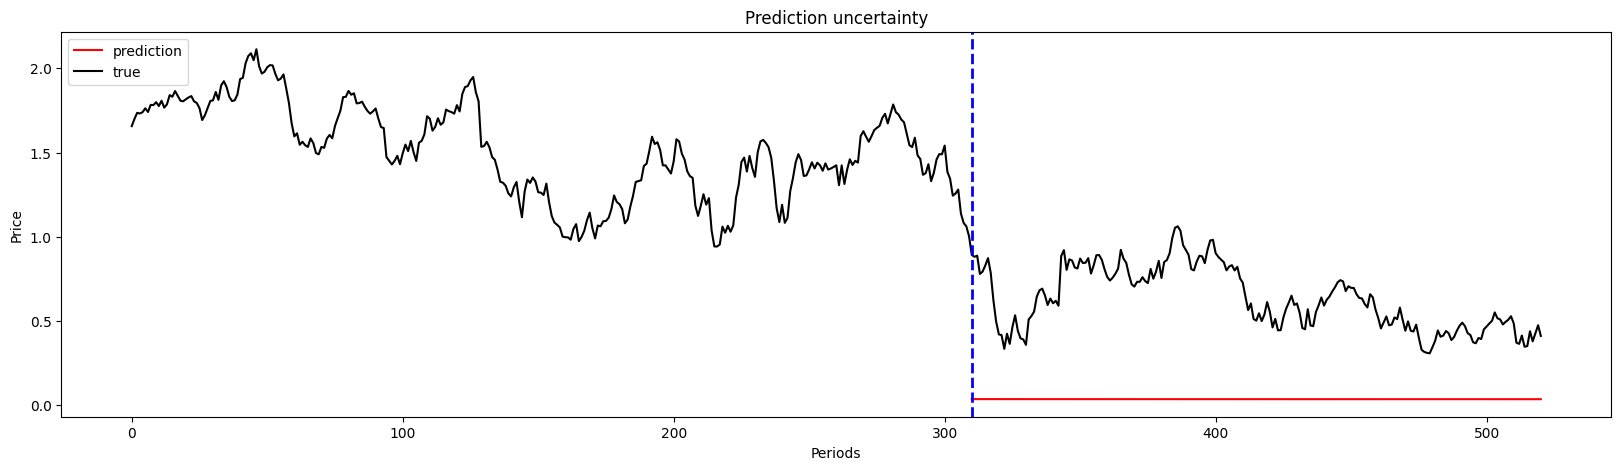

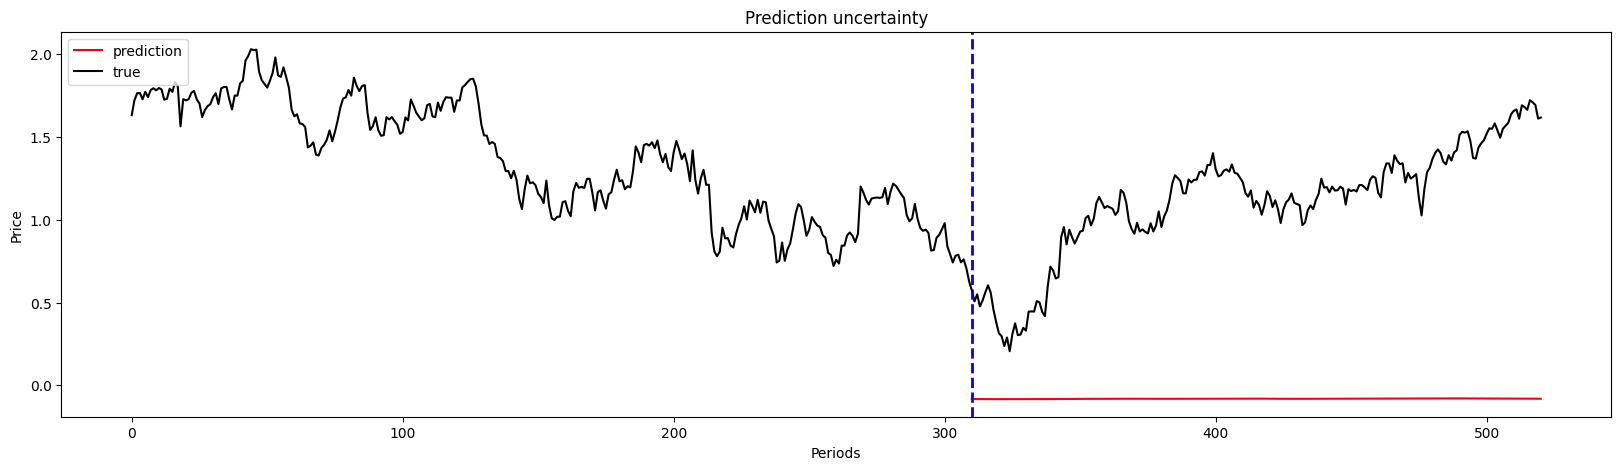

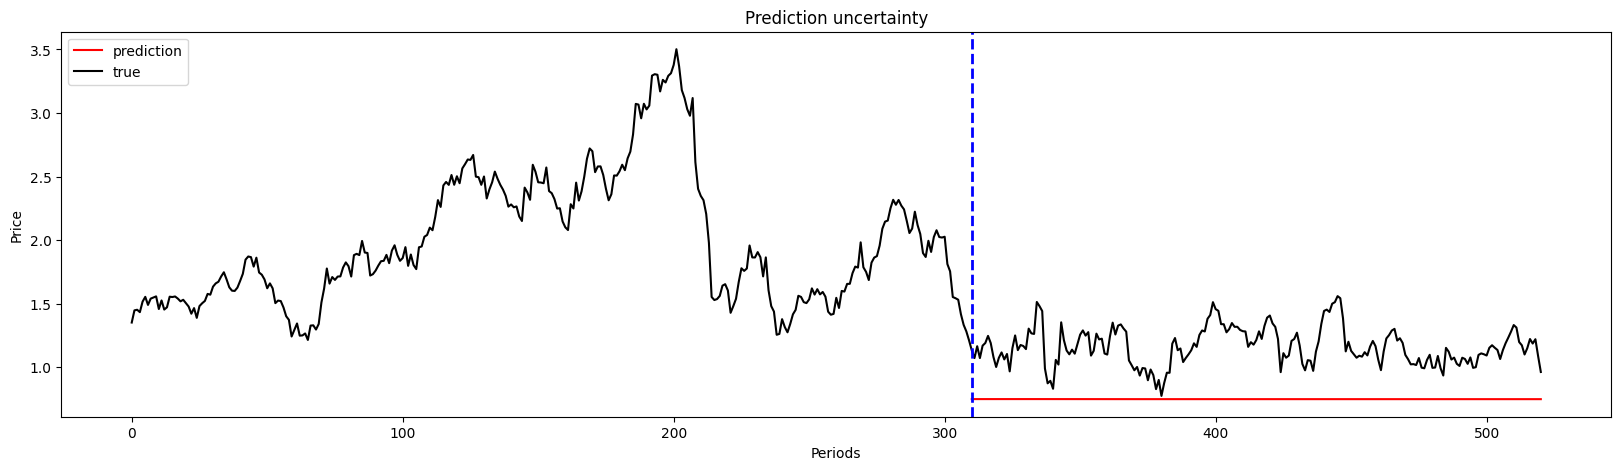

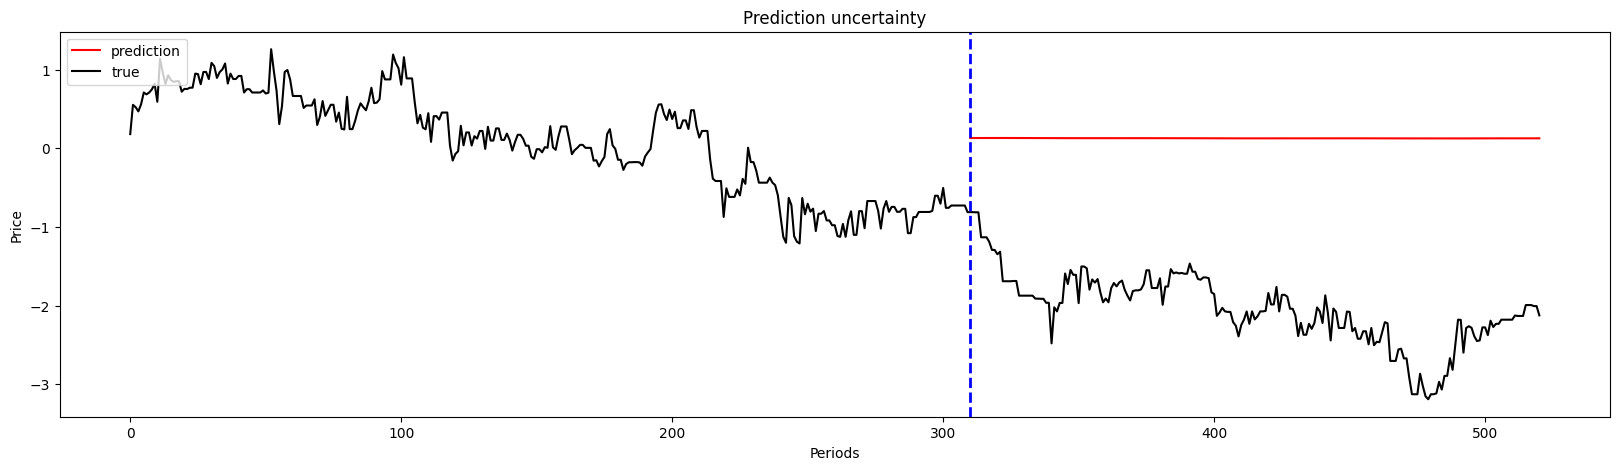

-----------------------------------------------------------------------------------------
| end of epoch  17 | time:  3.88s | valid loss 0.37506 | valid ppl     1.46
-----------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:389: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  18 |     6/   33 batches | lr 0.000035 | 78.59 ms | loss 0.48474 | ppl     1.62
| epoch  18 |    12/   33 batches | lr 0.000035 | 66.58 ms | loss 0.20411 | ppl     1.23
| epoch  18 |    18/   33 batches | lr 0.000035 | 68.79 ms | loss 0.10996 | ppl     1.12
| epoch  18 |    24/   33 batches | lr 0.000035 | 63.92 ms | loss 0.06538 | ppl     1.07
| epoch  18 |    30/   33 batches | lr 0.000035 | 69.55 ms | loss 0.24619 | ppl     1.28
torch.Size([521, 4]) torch.Size([521, 4])


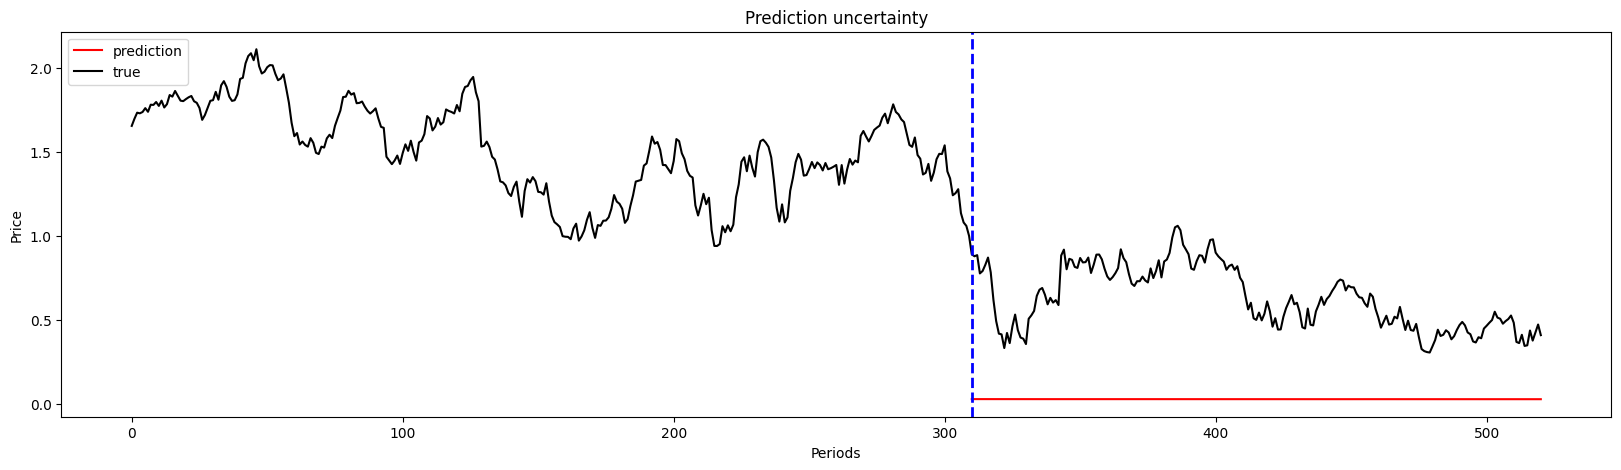

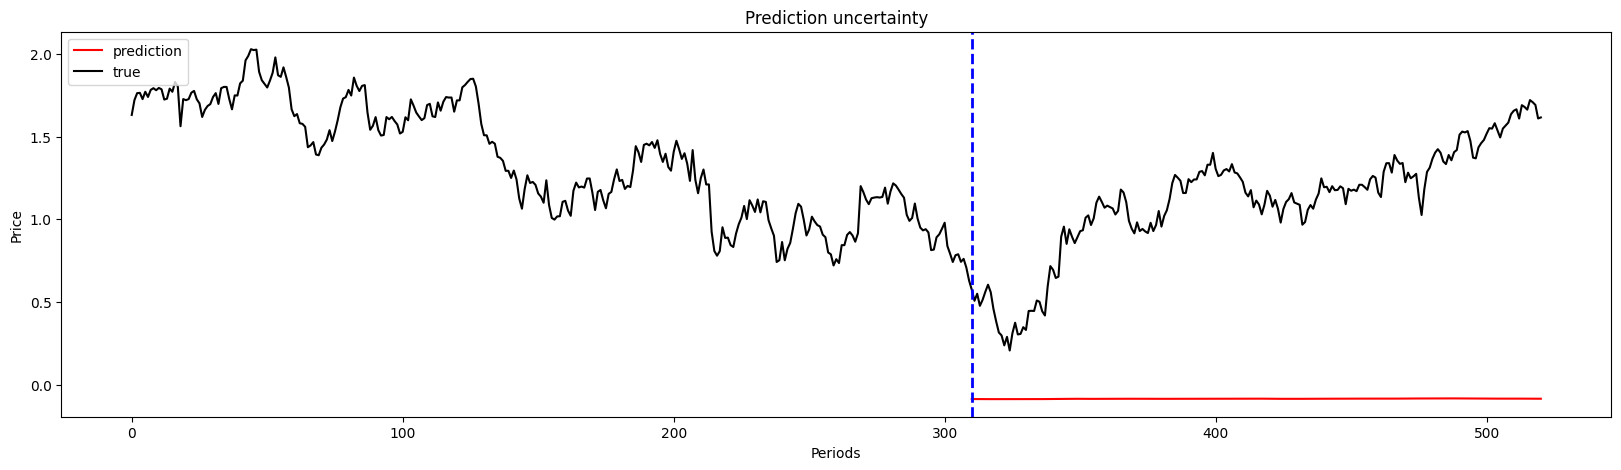

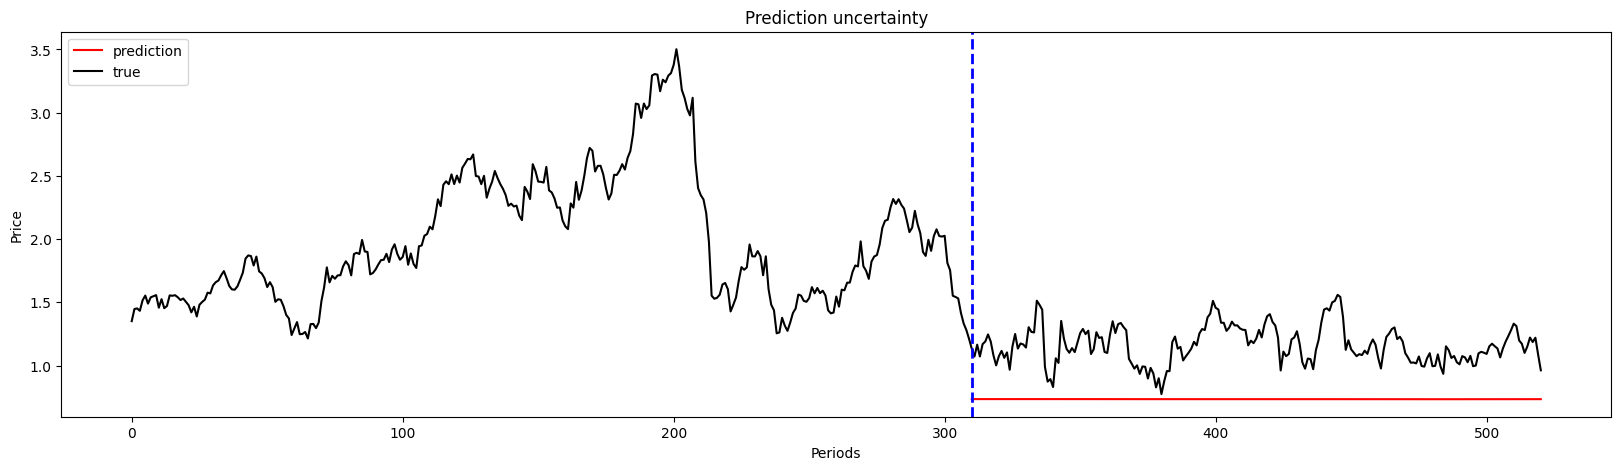

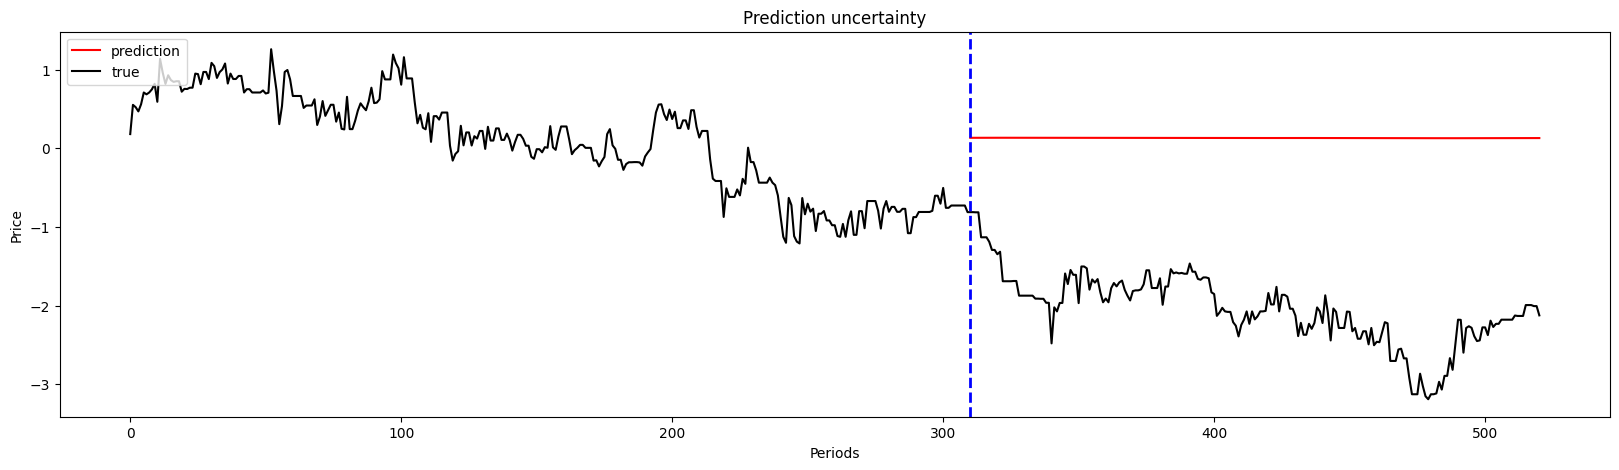

-----------------------------------------------------------------------------------------
| end of epoch  18 | time:  4.35s | valid loss 0.37834 | valid ppl     1.46
-----------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:389: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  19 |     6/   33 batches | lr 0.000034 | 76.72 ms | loss 0.48053 | ppl     1.62
| epoch  19 |    12/   33 batches | lr 0.000034 | 64.66 ms | loss 0.20088 | ppl     1.22
| epoch  19 |    18/   33 batches | lr 0.000034 | 64.13 ms | loss 0.10750 | ppl     1.11
| epoch  19 |    24/   33 batches | lr 0.000034 | 64.67 ms | loss 0.06404 | ppl     1.07
| epoch  19 |    30/   33 batches | lr 0.000034 | 66.33 ms | loss 0.24612 | ppl     1.28
torch.Size([521, 4]) torch.Size([521, 4])


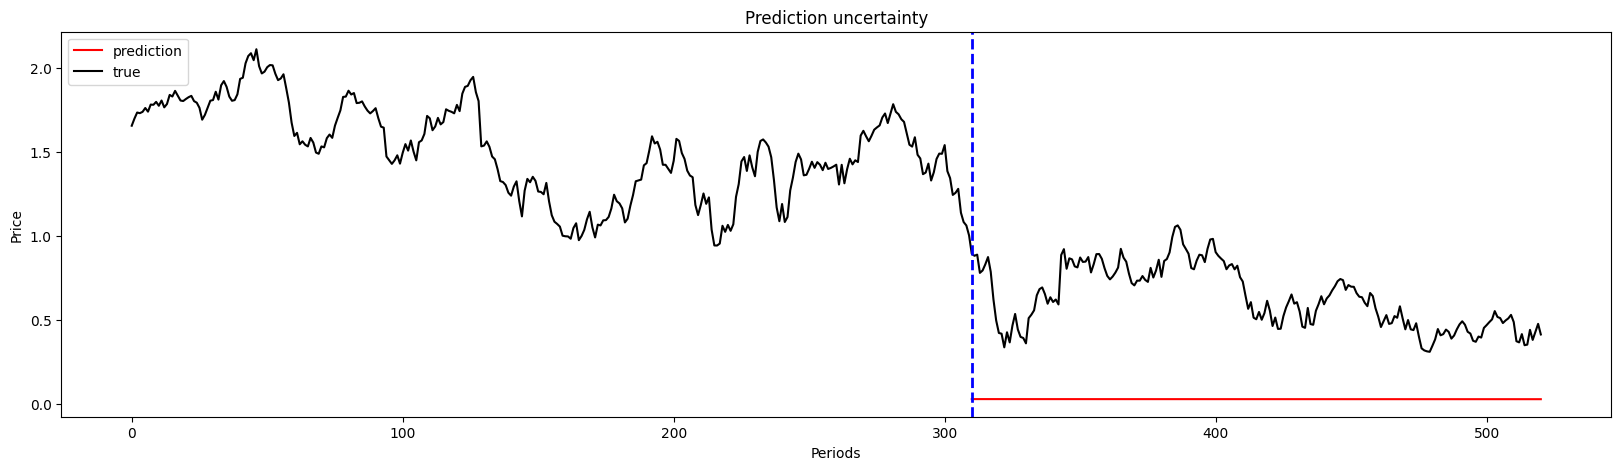

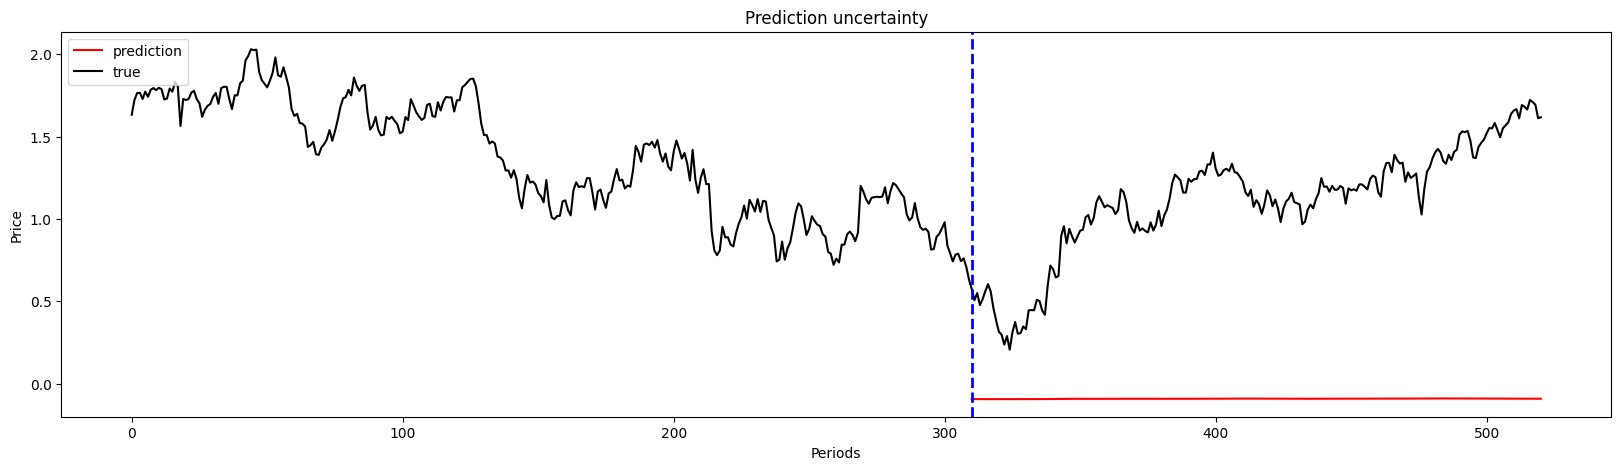

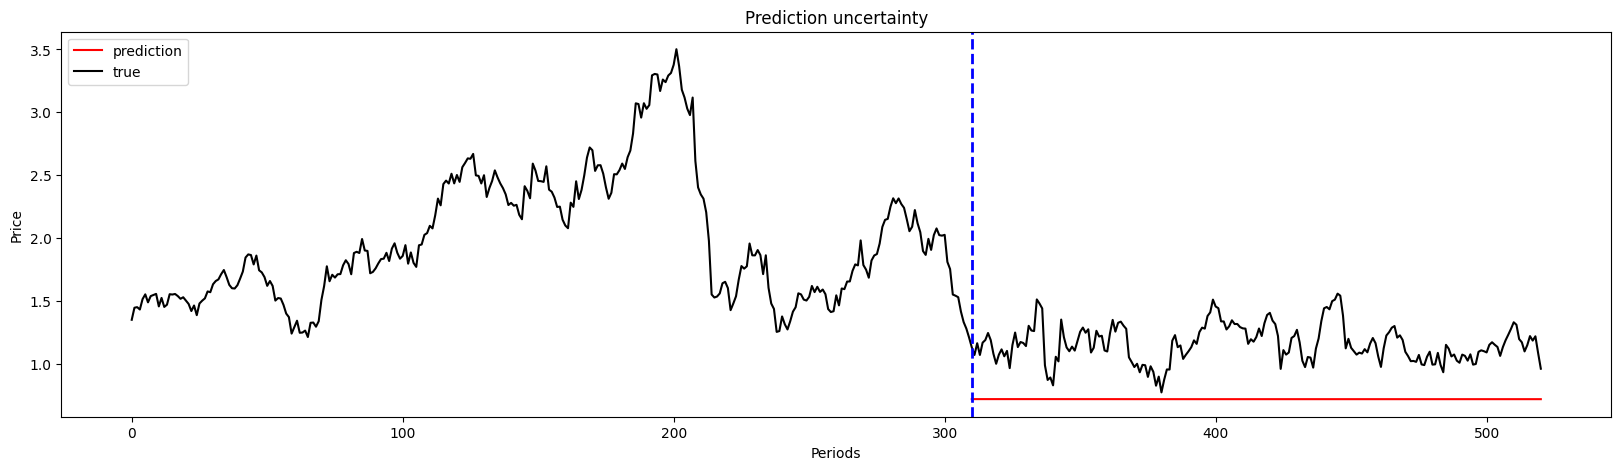

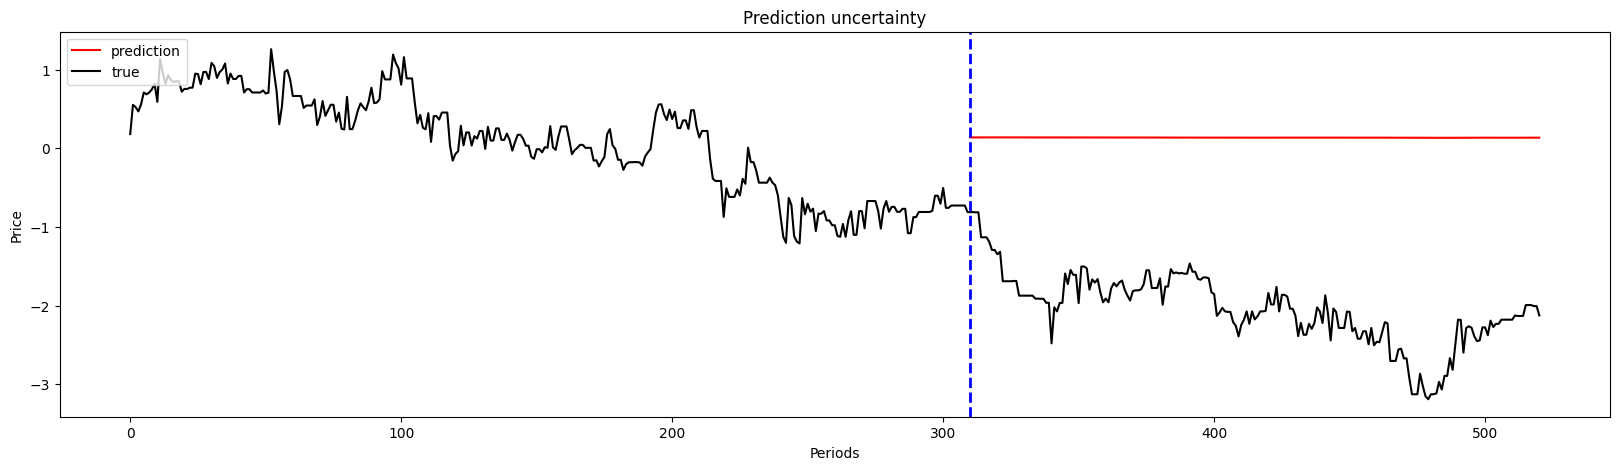

-----------------------------------------------------------------------------------------
| end of epoch  19 | time:  3.88s | valid loss 0.38172 | valid ppl     1.46
-----------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:389: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  20 |     6/   33 batches | lr 0.000033 | 74.54 ms | loss 0.47481 | ppl     1.61
| epoch  20 |    12/   33 batches | lr 0.000033 | 66.52 ms | loss 0.19840 | ppl     1.22
| epoch  20 |    18/   33 batches | lr 0.000033 | 66.55 ms | loss 0.10602 | ppl     1.11
| epoch  20 |    24/   33 batches | lr 0.000033 | 67.28 ms | loss 0.06248 | ppl     1.06
| epoch  20 |    30/   33 batches | lr 0.000033 | 66.80 ms | loss 0.24662 | ppl     1.28
torch.Size([521, 4]) torch.Size([521, 4])


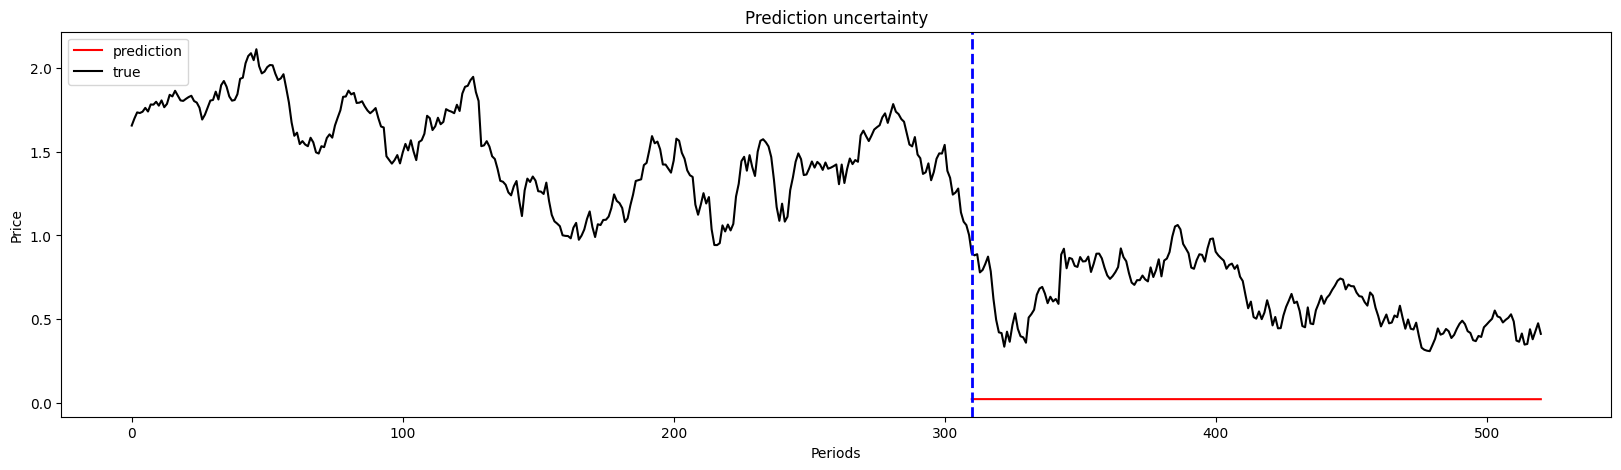

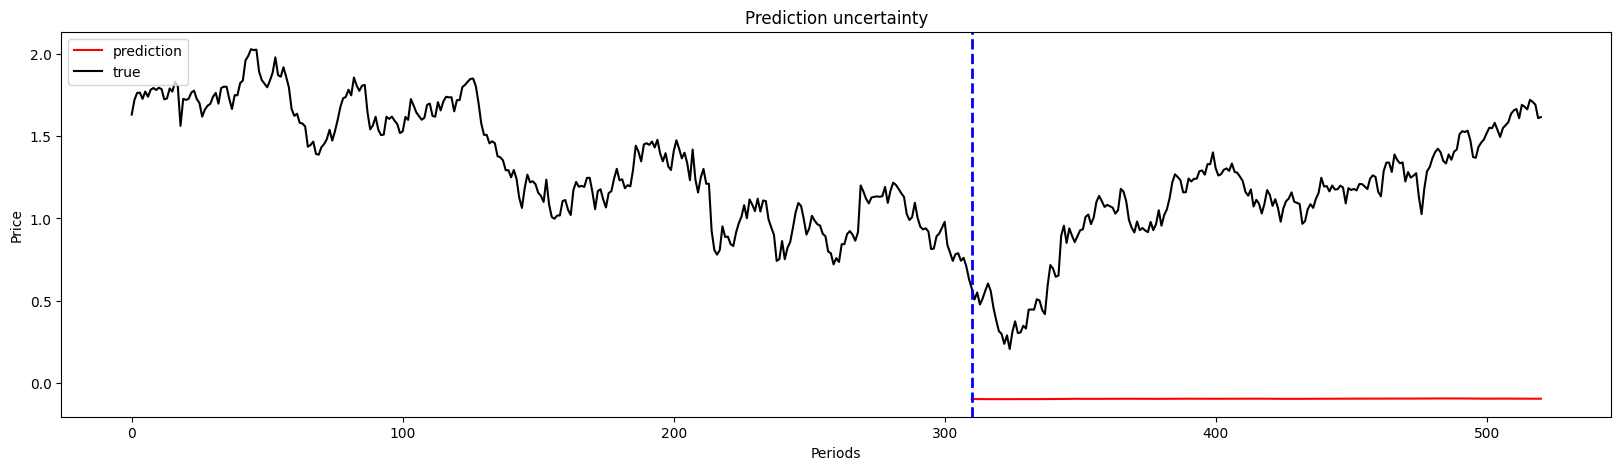

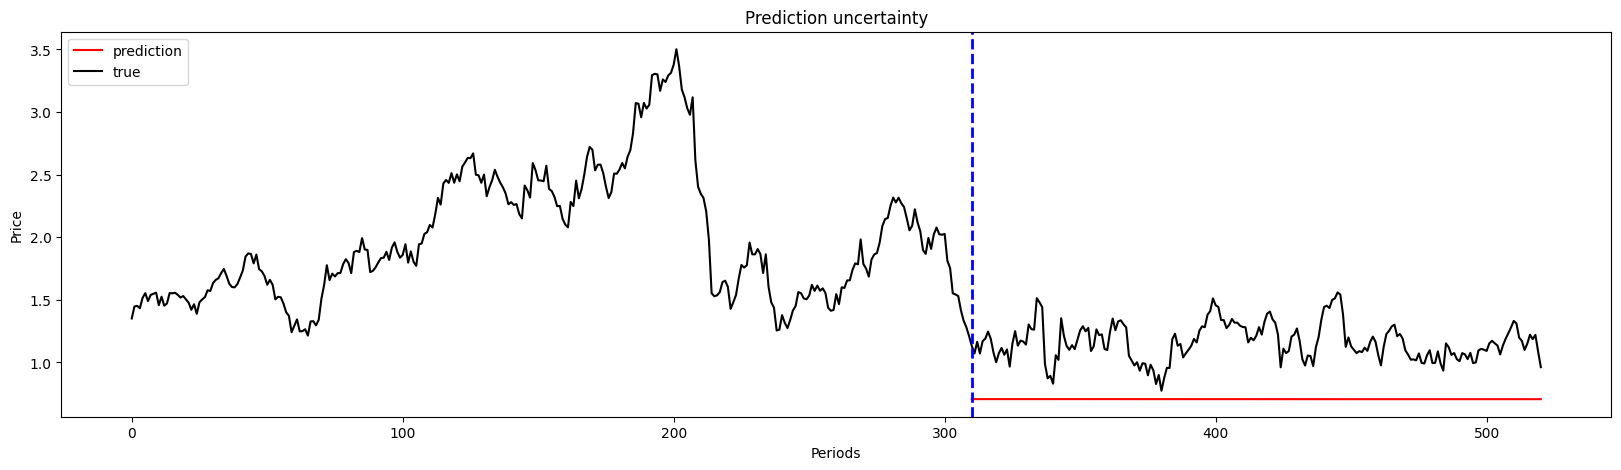

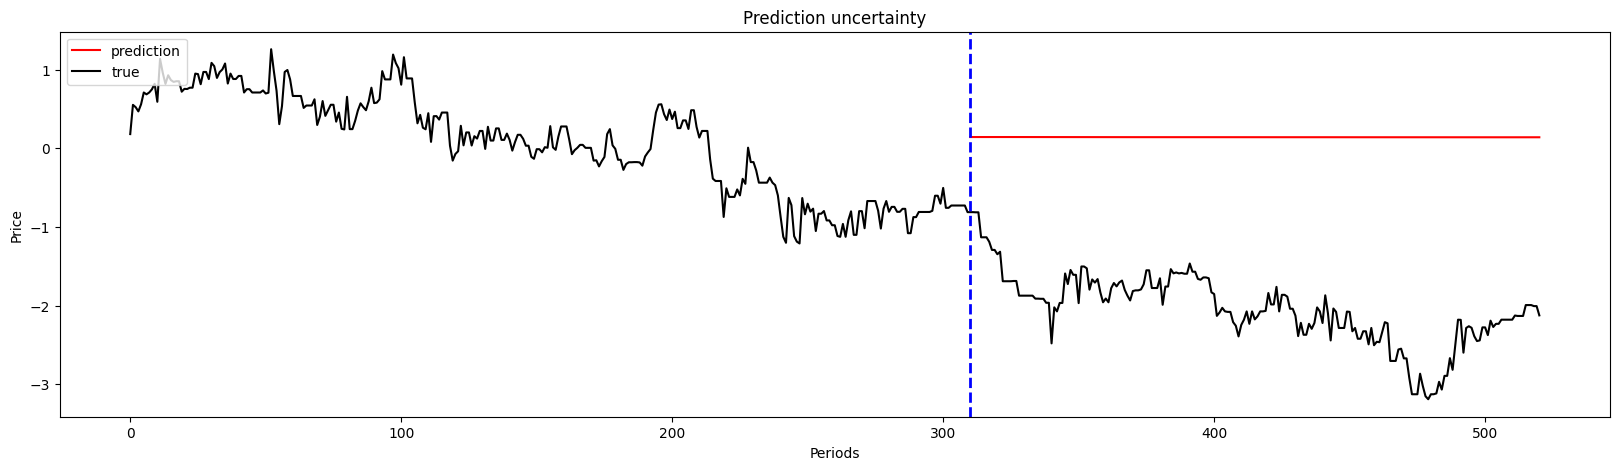

-----------------------------------------------------------------------------------------
| end of epoch  20 | time:  3.89s | valid loss 0.38491 | valid ppl     1.47
-----------------------------------------------------------------------------------------


In [252]:
train_data, val_data,scaler = get_data(data)
model = TransAm().to(device)

criterion = nn.MSELoss()
lr = 0.00005
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.98)

best_val_loss = float("inf")
epochs = 20 # The number of epochs
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(train_data)


    if(epoch % 1 is 0):
        val_loss = plot(model, val_data,epoch,scaler)
        # predict_future(model, val_data,200,epoch,scaler)
    else:
        val_loss = evaluate(model, val_data)

    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.5f} | valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                     val_loss, math.exp(val_loss)))
    print('-' * 89)

    #if val_loss < best_val_loss:
    #    best_val_loss = val_loss
    #    best_model = model

    scheduler.step()